<a href="https://colab.research.google.com/github/AdrianDiazGaxiola/Proyecto-Final/blob/main/IPCC_Procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Este código se empleará para limpiar los datos de los archivos IPCC de los años 1990 a 2019

In [4]:
!pip install numpy pandas info_gain

Se importan las librerías a utilizar

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from info_gain import info_gain
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Aquí se leen los archivos con los datos en bruto y se guardan como dataframes en un diccionario, además se guardan en una lista los nombres de las columnas y se agregan a cada dataframe como los nombres de las columnas

In [6]:
IPCC = {}
Enc = ["Categoría", "CO2", "CH4", "N2O", "HFC-23", "HFC-410A", "HFC-43-10-mee", "HFC-125", "HFC-134", "HFC-134a", "HFC-404A", "HFC-407C", "HFC-507a", "HFC-152a", "HFC-227ea", "HFC-236fa", "HFC-365mfc/227ea", "HFC-365mfc", "HFC-245fa", "HFC-32", "CF4", "C2F6", "C3F8", "C4F6", "c-C4F8", "C5F8", "NF3", "SF6", "EMISIONES NETAS", "EMISIONES (sin 3B Y 3D)", "", "Carbono negro"]

for i in range(1990,2020):
  url = "https://github.com/AdrianDiazGaxiola/Proyecto-Final/raw/main/Data/IPCC/IPCC_%d.csv" % i
  IPCC[i] = pd.read_csv(url, names = Enc, encoding = 'ISO-8859-1', na_filter=False, thousands=',')
  IPCC[i] = IPCC[i].drop(columns=['', 'EMISIONES (sin 3B Y 3D)'])

#Se lee aparte el archivo del año 2014 ya que está en un formato diferente
url = 'https://github.com/AdrianDiazGaxiola/Proyecto-Final/raw/main/Data/IPCC/IPCC_2014.csv'
IPCC[2014] = pd.read_csv(url, names = Enc, na_filter=False, thousands=',')
IPCC[2014] = IPCC[2014].drop(columns=['', 'EMISIONES (sin 3B Y 3D)'])


Se prueba que los archivos se leyeron correctamente, descargando uno de ellos

In [7]:
df = IPCC[2014]

df.to_csv("IPCC 90 Prueba.csv", encoding='ISO-8859-1', index=False)
from google.colab import files
files.download("IPCC 90 Prueba.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
IPCC[2014].head(10)

Categoría  ...        Carbono negro
0                                               ...                     
1  CATEGORÍA / FUENTE / SUBFUENTE \nDE EMISIÓN  ...  Carbono negro\n(Gg)
2                                               ...                     
3                                               ...                     
4                                               ...                     
5                   Potencial de calentamiento  ...                     
6                                               ...                     
7                 EMISIONES NETAS (Gg de CO2e)  ...               67.056
8                                  [1] Energía  ...               60.219
9    [1A] Actividades de quema del combustible  ...               55.622

[10 rows x 30 columns]

Aquí se guardan en una lista las Categorías de las fuentes de emisión para después usarlas.
Se eliminan los primeros 8 elementos ya que no son necesarios (como se copiaron del archivo inicial, estos elemento sobran)

In [9]:
df = IPCC[1990]
Cat = df["Categoría"].tolist()

#Se eliminan los 7 primeros elementos de la lista
for i in range (7):
  Cat.pop(0)

Cat.pop(169)

print(Cat)

['EMISIONES NETAS (Gg de CO2e)', '[1] Energía', '[1A] Actividades de quema del combustible', '[1A1] Industrias de la energía', '[1A1a] Actividad principal producción de electricidad y calor', '[1A1b] Refinación del petróleo', '[1A1c] Manufactura de combustibles sólidos y otras industrias de la energía', '[1A2] Industrias manufactura y de la construcción', '[1A2a] Hierro y acero', '[1A2b] Metales no ferrosos', '[1A2c] Sustancias químicas', '[1A2d] Pulpa, papel e imprenta', '[1A2e] Procesamiento de alimentos, bebidas y tabaco', '[1A2f] Minerales no metálicos', '[1A2g] Equipo de transporte', '[1A2h] Maquinaria', '[1A2i] Minería (con excepción de combustibles) y cantería', '[1A2j] Madera y productos de la madera', '[1A2k] Construcción', '[1A2l] Textiles y cueros', '[1A2m] Industria no especificada', '[1A3] Transporte', '[1A3a] Aviación civil', '[1A3b] Autotransporte', '[1A3c] Ferrocarriles', '[1A3d] Navegación marítima y fluvial', '[1A3e] Otro transporte', '[1A4] Otros sectores', '[1A4a] C

Aquí se crea un dataframe por categoría de fuente de emisión donde se guardan todos sus datos de las cantidades de contaminantes emitidos por año

In [10]:
IPCC_por_cat = {} #Se crea un diccionario para las IPCC por categoría

#Se declaran los dataframe y se elimina la columna vacía y la de Emisiones (sin 3B y 3D)
for i in Cat:
  IPCC_por_cat[i] = pd.DataFrame(columns=Enc)
  IPCC_por_cat[i] = IPCC_por_cat[i].drop(columns=['', 'EMISIONES (sin 3B Y 3D)'])

#Ciclo para copiar los datos a los nuevos dataframe
for i in range(1990, 2020):
  df = IPCC[i]

  #Ciclo para concatenar la fila correspondiente a la categoría de la fuente de emisión con la del año correspondiente
  for j in Cat:
    IPCC_por_cat[j] = IPCC_por_cat[j].append(df.loc[df['Categoría'] == j], ignore_index=True)
    IPCC_por_cat[j].at[i-1990, 'Categoría'] = i #En la columan de 'Categoría' se guarda el año en el que se encuentra

#Se cambia el nombre de la columna 'Categoría' por 'ANIO', y se reemplazan los valores vacíos con 'NaN'
for i in Cat:
  IPCC_por_cat[i].rename(columns = {'Categoría':'ANIO'}, inplace = True)
  IPCC_por_cat[i] = IPCC_por_cat[i].replace(r'^\s*$', np.nan, regex=True)

In [11]:
print(IPCC_por_cat['[1] Energía'])

    ANIO          CO2         CH4  ... SF6  EMISIONES NETAS  Carbono negro
0   1990  287,887.541  15,757.714  ... NaN      306,533.434         73.109
1   1991  298,614.787  16,023.514  ... NaN      317,662.793         74.688
2   1992  299,915.893  16,005.651  ... NaN      318,971.083         76.234
3   1993  301,303.624  16,892.611  ... NaN      321,293.992         76.965
4   1994  321,255.043  16,871.522  ... NaN      341,343.932         80.004
5   1995  309,168.372  18,489.596  ... NaN      330,756.743         78.214
6   1996  322,696.393  24,314.066  ... NaN      350,170.926         78.738
7   1997  339,872.616  29,098.558  ... NaN      372,277.530         84.447
8   1998  360,117.934  30,985.053  ... NaN      394,475.780         88.263
9   1999  352,617.358  27,077.324  ... NaN      383,000.078         84.830
10  2000  365,422.280  28,213.073  ... NaN      397,055.093         85.153
11  2001  363,505.282  26,498.874  ... NaN      393,369.062         79.613
12  2002  383,299.479  25

Se guardan en una nueva lista los sectores de emisiones que no están vacíos

In [12]:
print(Cat)
feats = list(filter(None, Cat))
feats.pop(len(feats)-1)
feats.pop(len(feats)-2)
print(feats)

['EMISIONES NETAS (Gg de CO2e)', '[1] Energía', '[1A] Actividades de quema del combustible', '[1A1] Industrias de la energía', '[1A1a] Actividad principal producción de electricidad y calor', '[1A1b] Refinación del petróleo', '[1A1c] Manufactura de combustibles sólidos y otras industrias de la energía', '[1A2] Industrias manufactura y de la construcción', '[1A2a] Hierro y acero', '[1A2b] Metales no ferrosos', '[1A2c] Sustancias químicas', '[1A2d] Pulpa, papel e imprenta', '[1A2e] Procesamiento de alimentos, bebidas y tabaco', '[1A2f] Minerales no metálicos', '[1A2g] Equipo de transporte', '[1A2h] Maquinaria', '[1A2i] Minería (con excepción de combustibles) y cantería', '[1A2j] Madera y productos de la madera', '[1A2k] Construcción', '[1A2l] Textiles y cueros', '[1A2m] Industria no especificada', '[1A3] Transporte', '[1A3a] Aviación civil', '[1A3b] Autotransporte', '[1A3c] Ferrocarriles', '[1A3d] Navegación marítima y fluvial', '[1A3e] Otro transporte', '[1A4] Otros sectores', '[1A4a] C

Se crean las gráficas de las emisiones a través de los años de los primeros 60 sectores

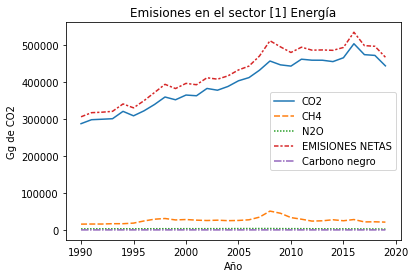

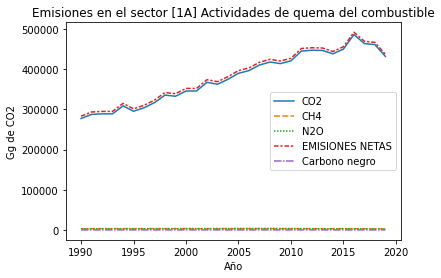

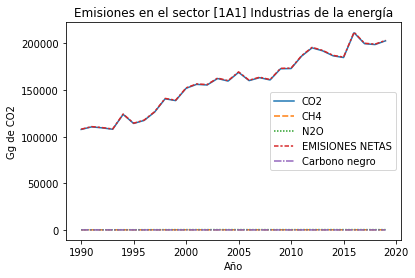

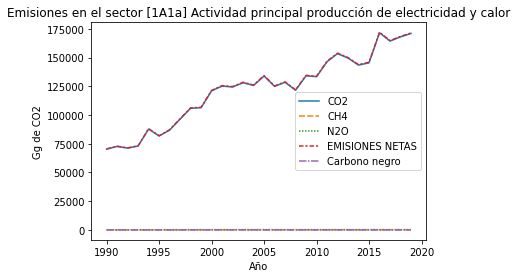

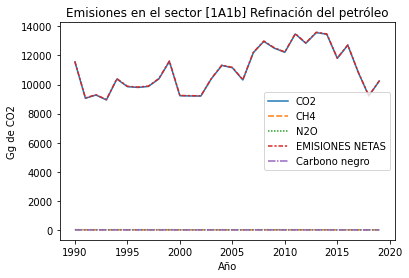

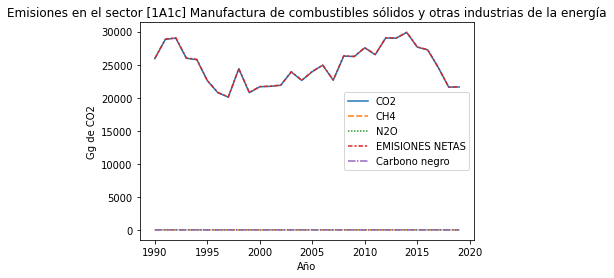

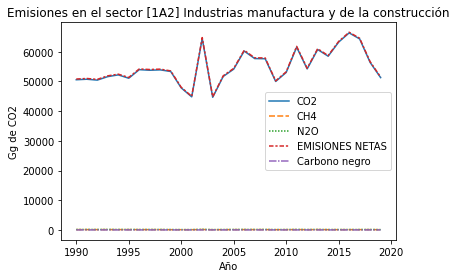

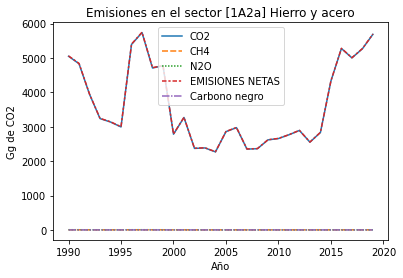

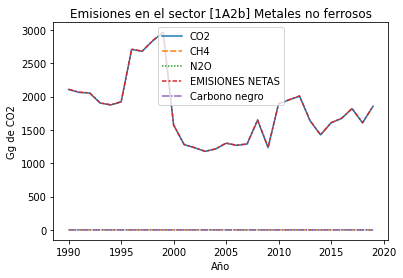

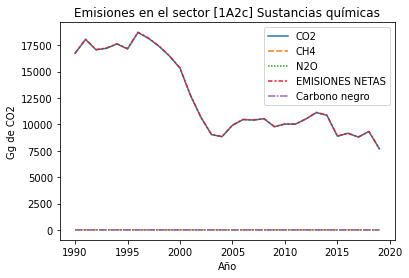

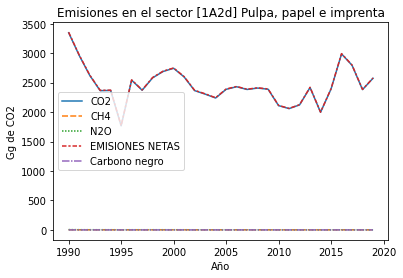

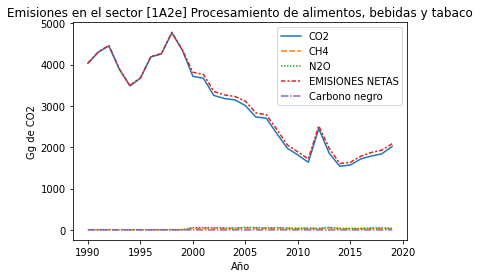

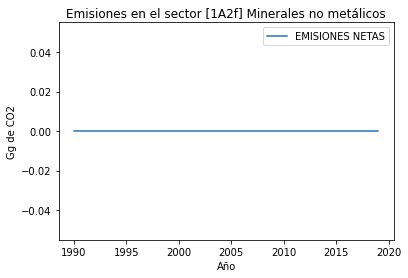

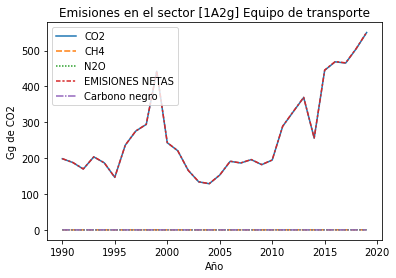

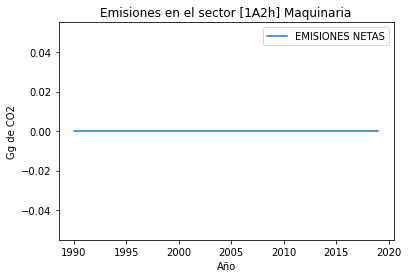

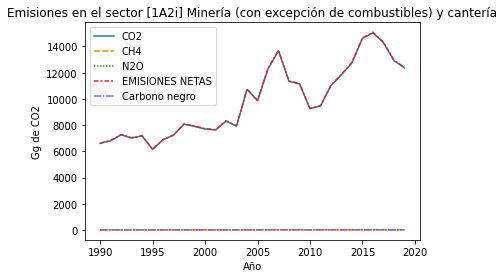

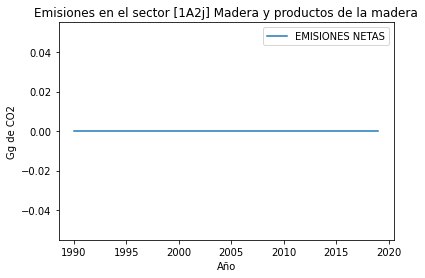

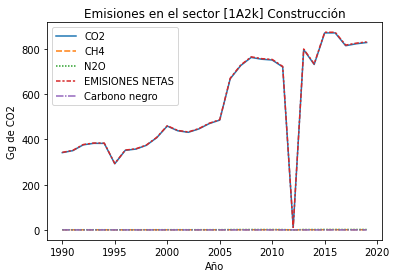

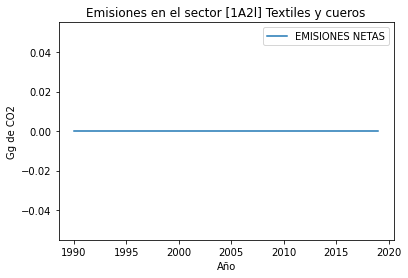

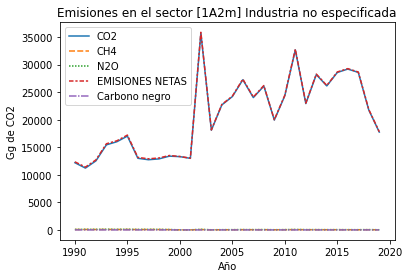

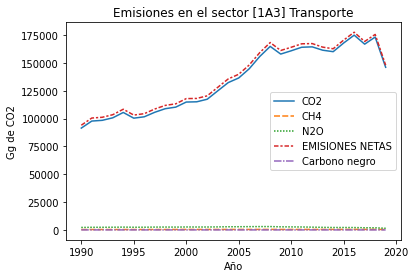

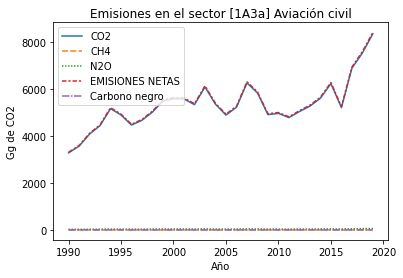

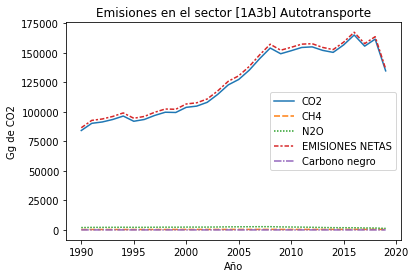

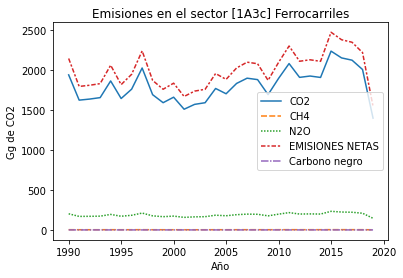

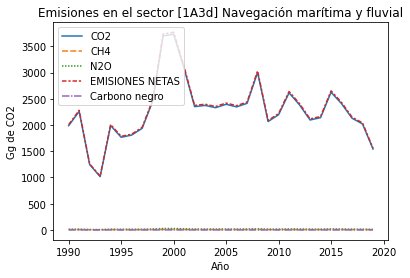

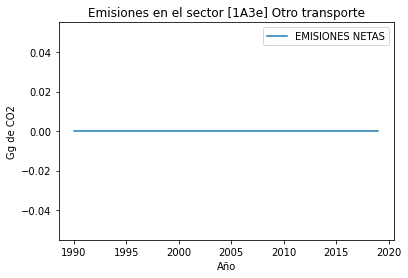

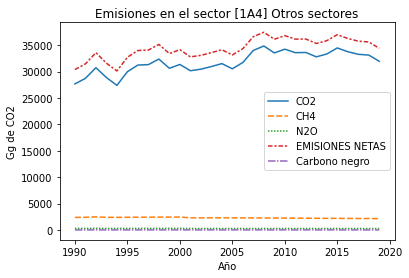

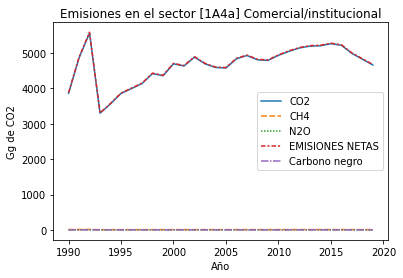

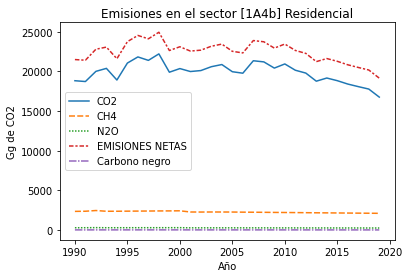

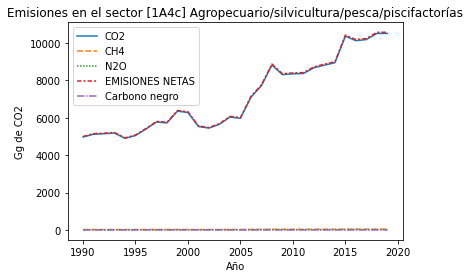

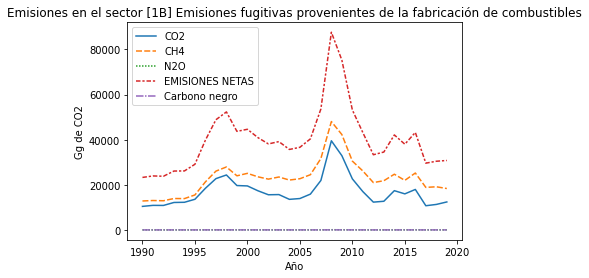

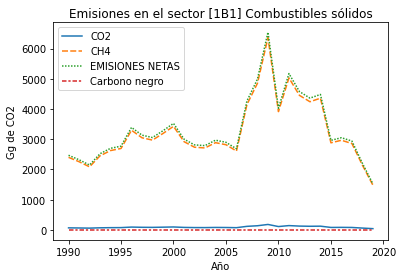

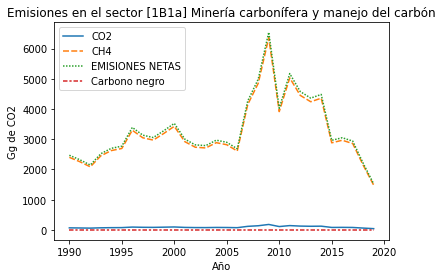

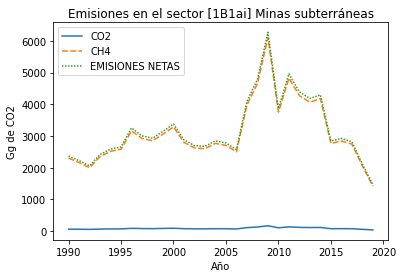

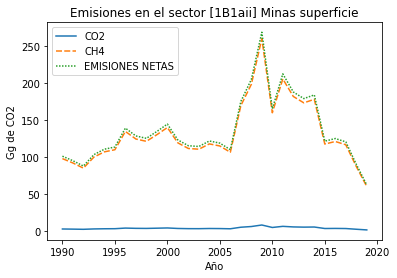

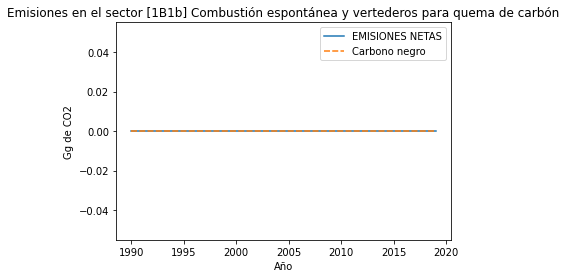

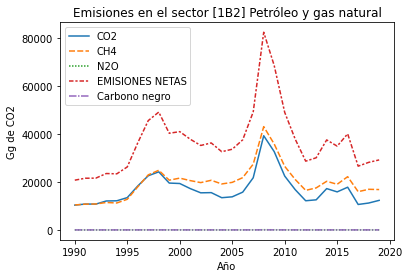

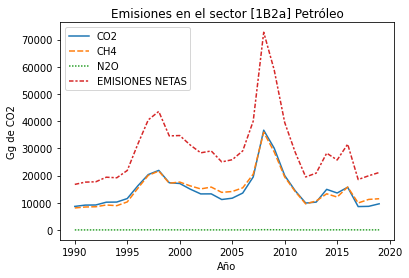

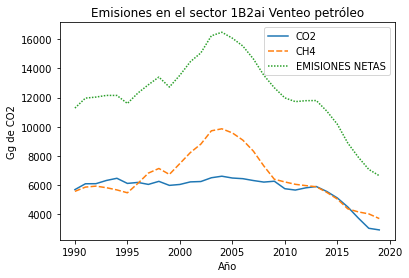

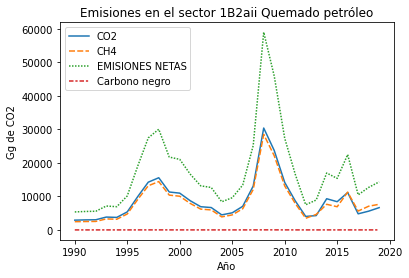

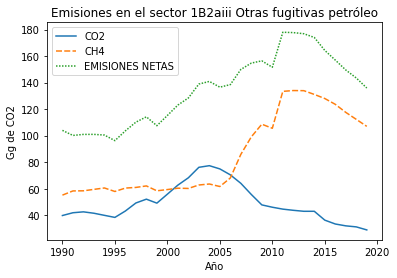

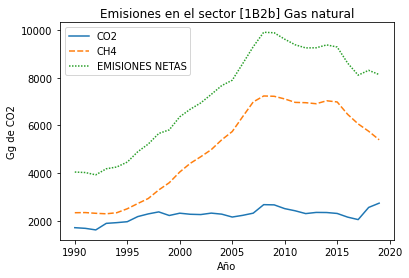

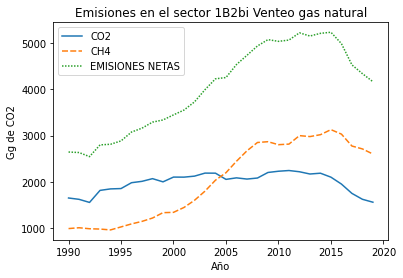

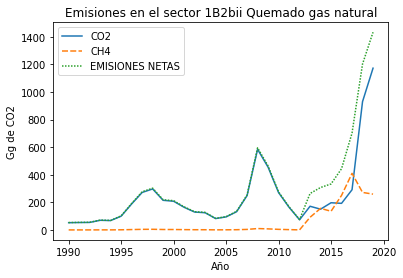

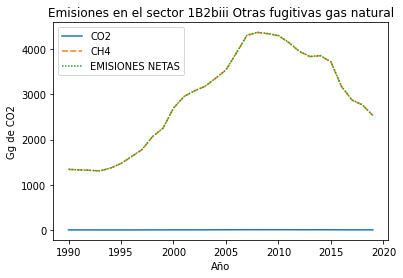

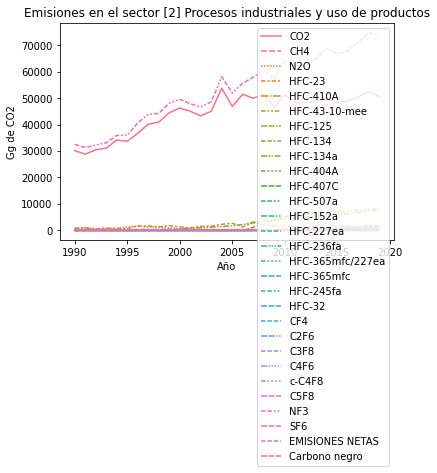

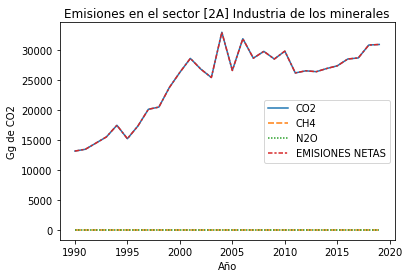

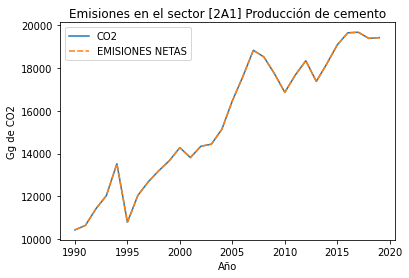

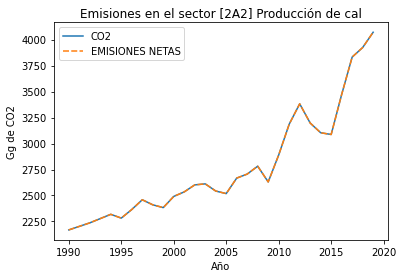

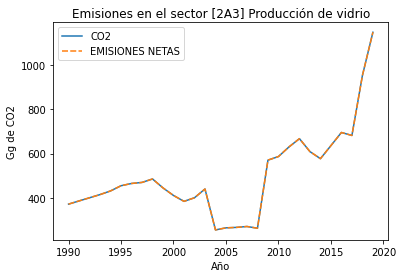

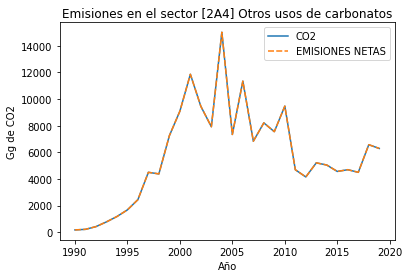

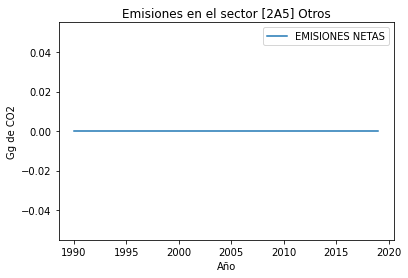

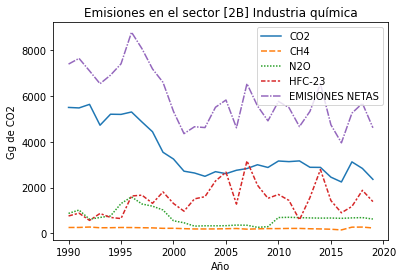

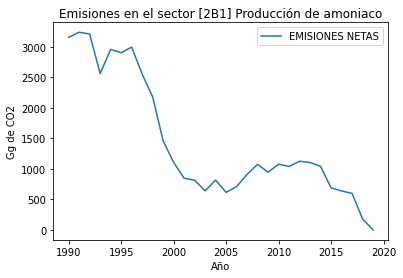

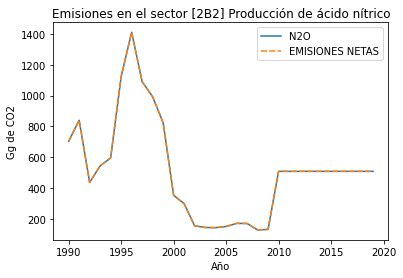

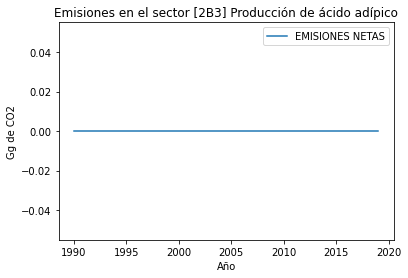

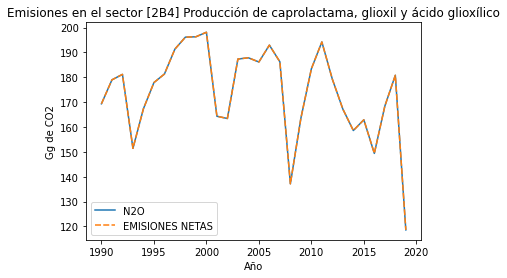

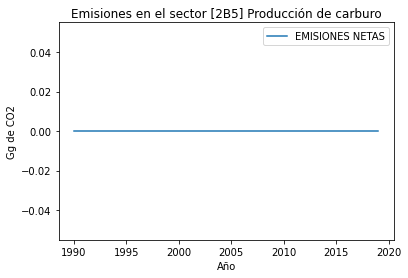

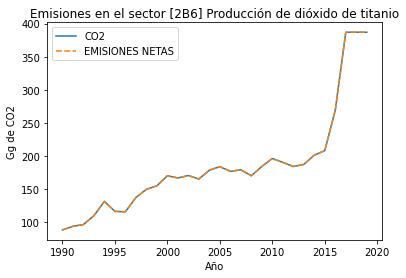

In [13]:
IPCC_por_cat_limpio = {}

for i in feats[1:60]:

  df = IPCC_por_cat[i]
    
  #Se eliminan las columnas que tienen solo ceros para no graficarlas
  df = df.loc[:, (df != 0).any(axis=0)]
  
  #Se eliminan las columnas vacías
  df = df.dropna(axis='columns')

  df = df.set_index("ANIO", drop=True)

  #Se convierten las strings que contienen números separados por comas a floats
  df = df.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

  df = df.apply(pd.to_numeric)

  #Se guarda el nuevo dataframe ordenado del sector en un nuevo diccionario
  IPCC_por_cat_limpio[i] = df

  #Se crea la gráfica
  plt.figure()
  ax = sns.lineplot(data=df)
  ax.set(xlabel = "Año", ylabel='Gg de CO2', title = "Emisiones en el sector %s" % i.strip())
  plt.show()


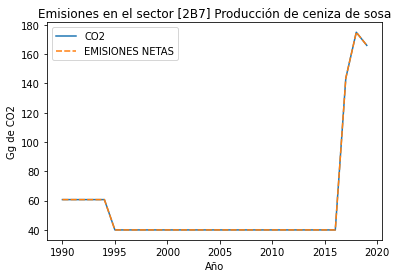

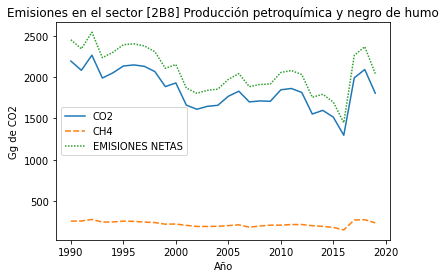

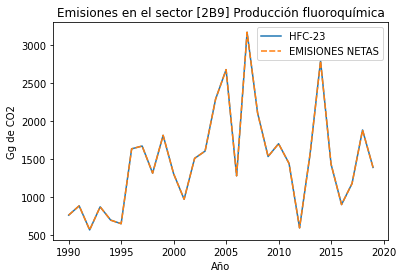

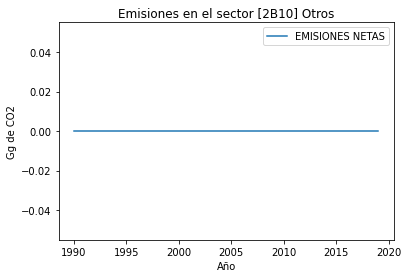

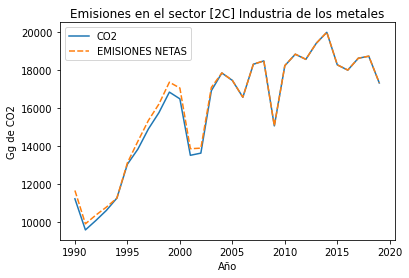

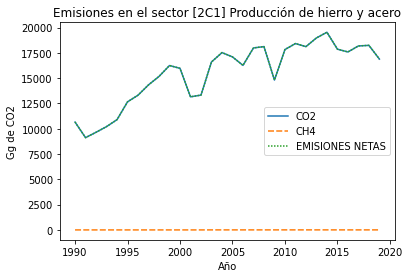

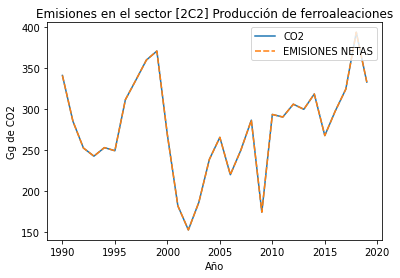

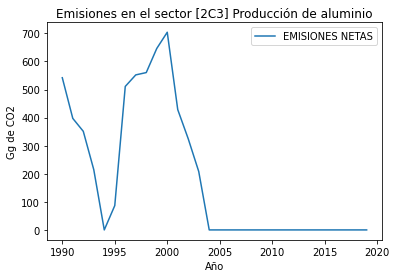

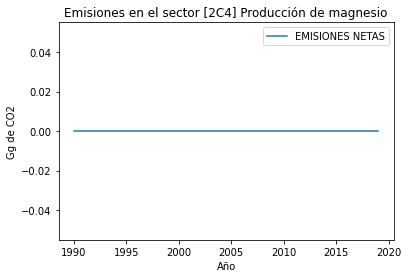

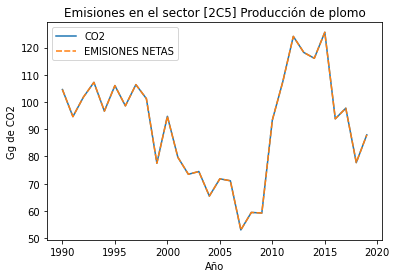

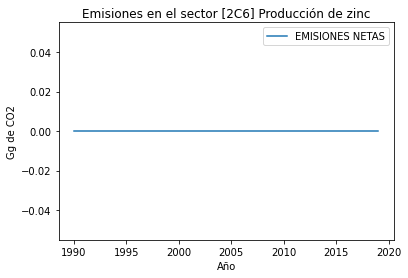

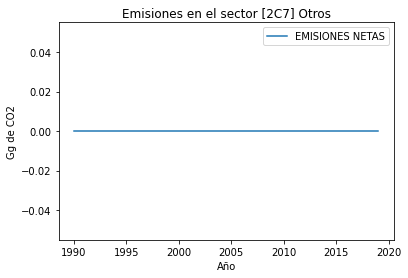

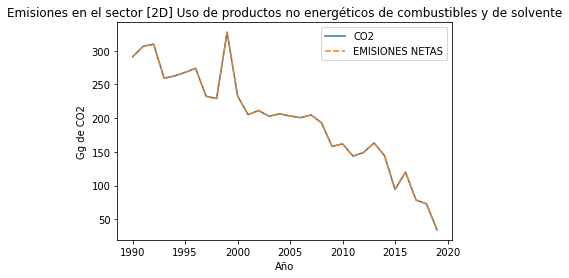

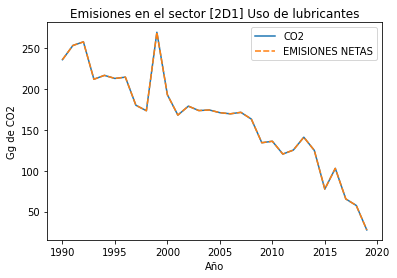

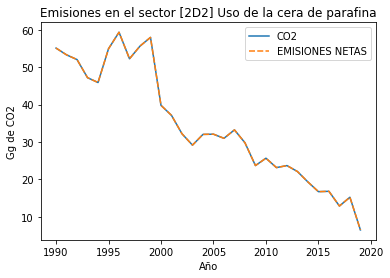

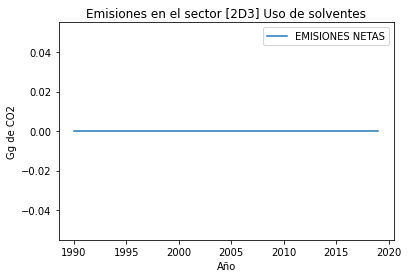

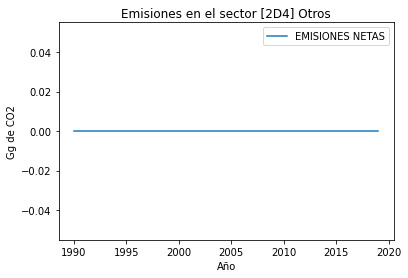

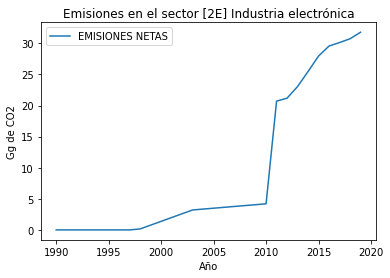

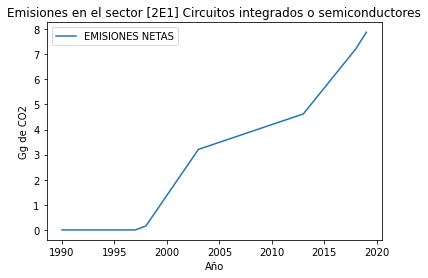

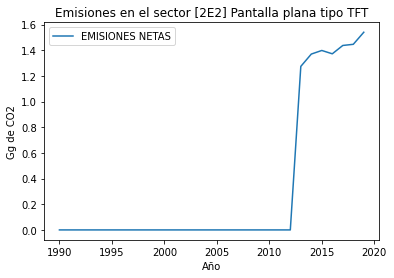

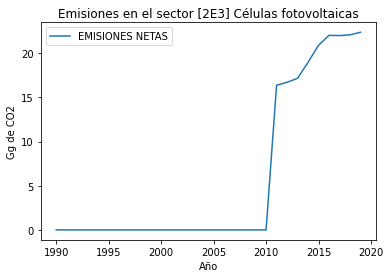

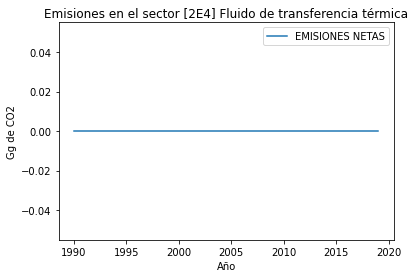

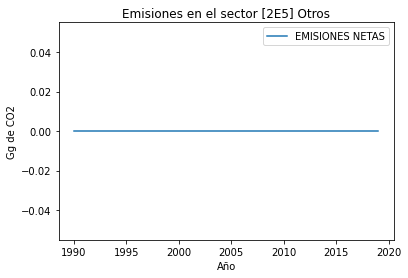

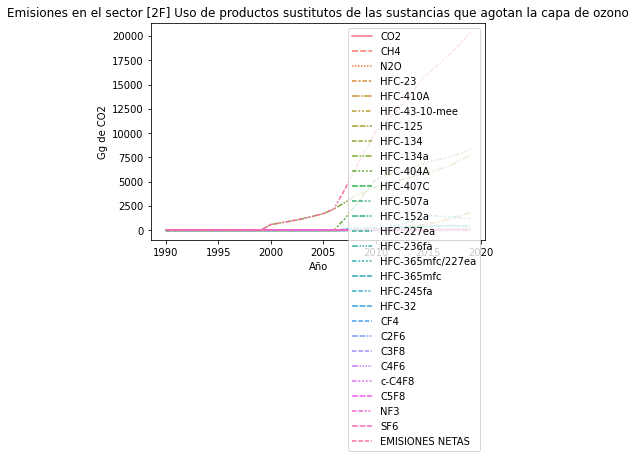

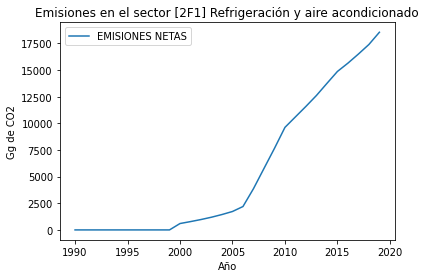

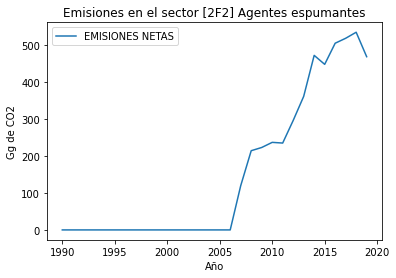

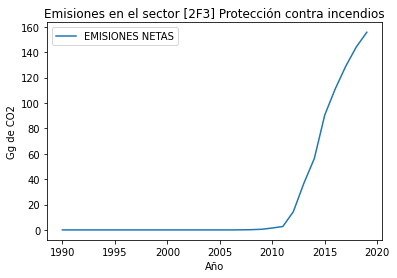

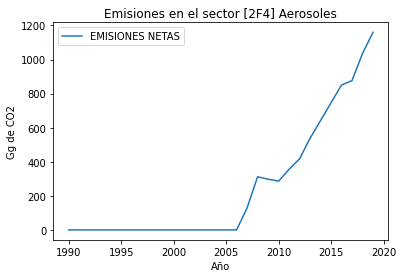

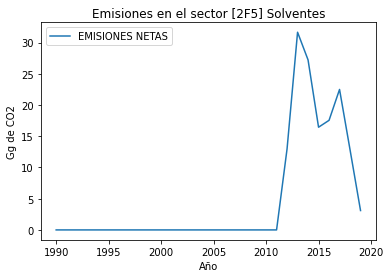

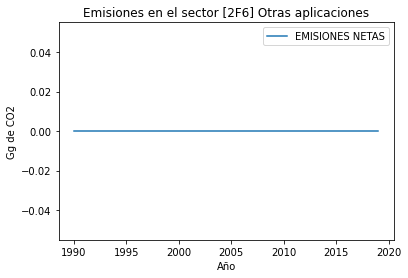

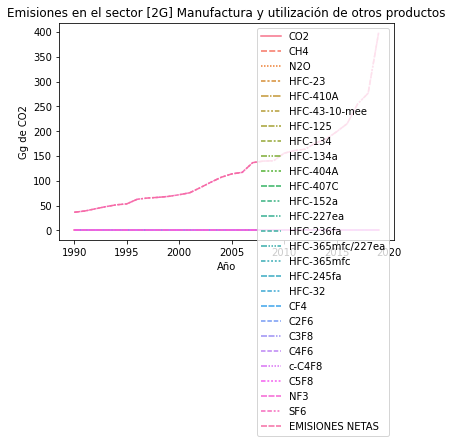

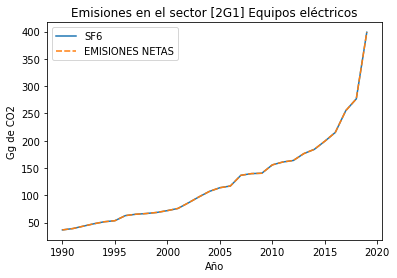

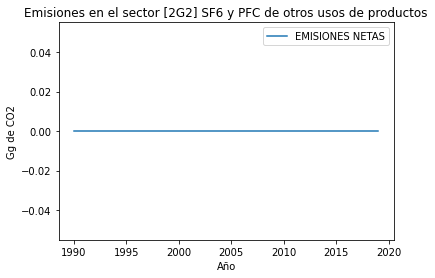

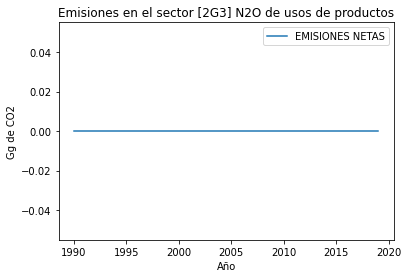

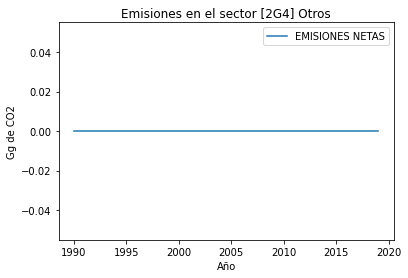

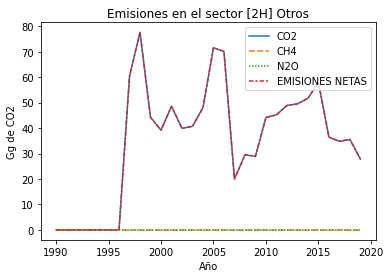

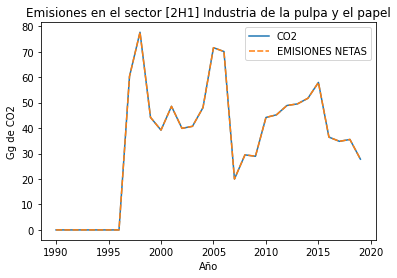

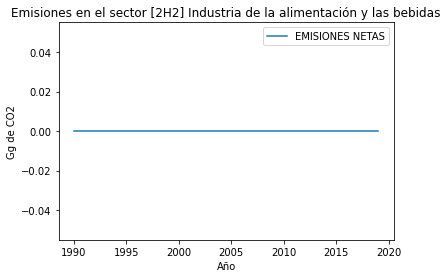

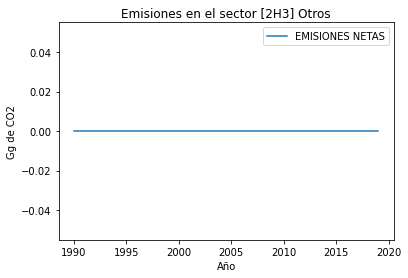

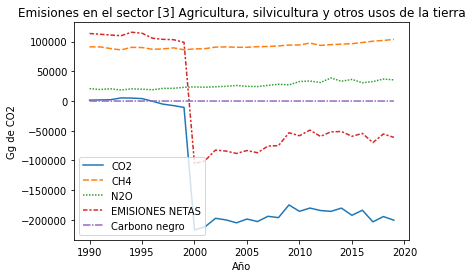

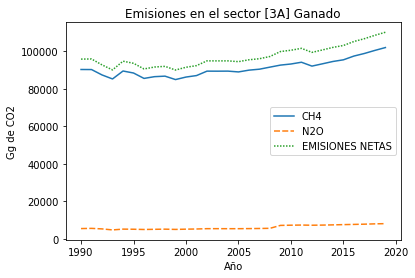

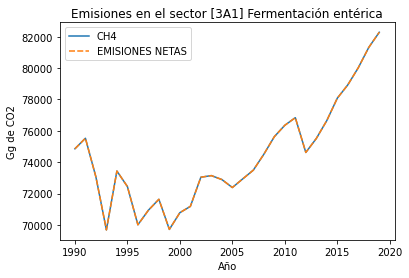

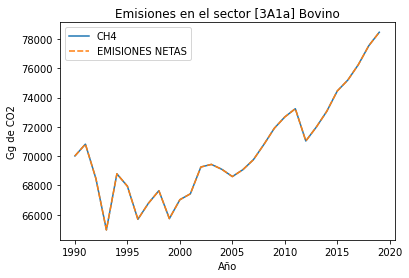

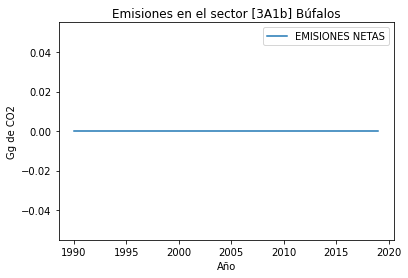

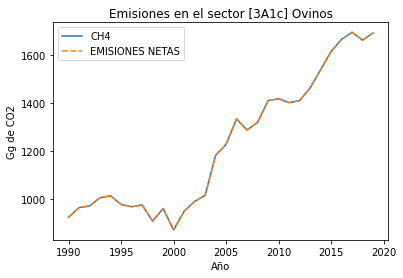

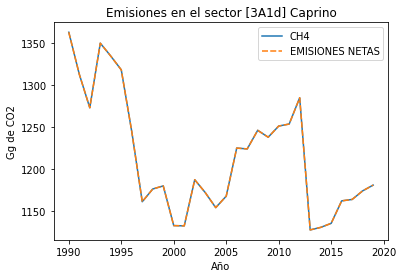

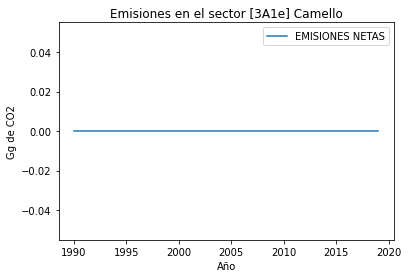

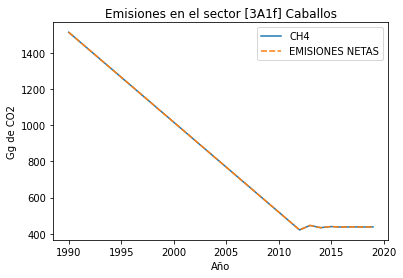

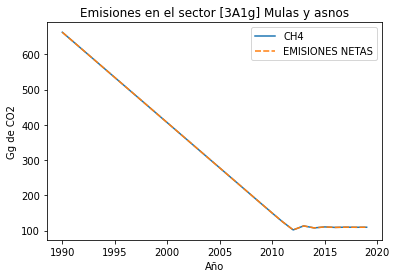

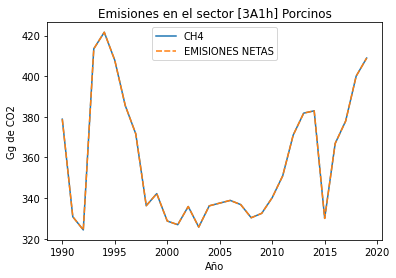

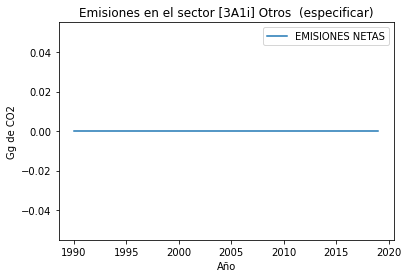

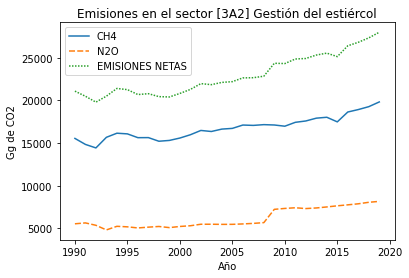

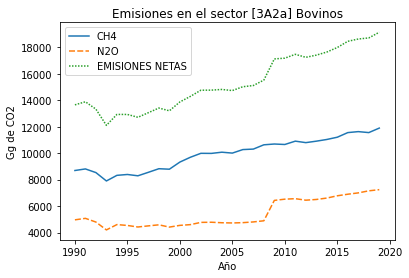

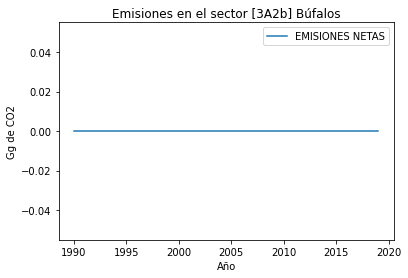

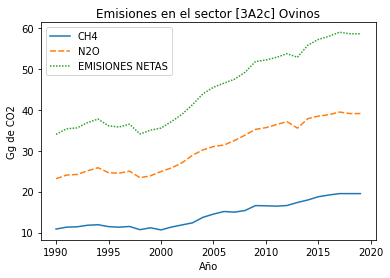

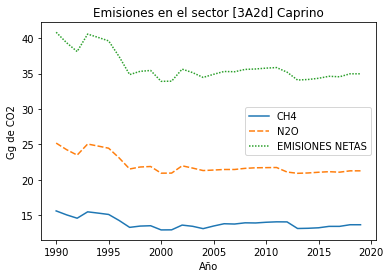

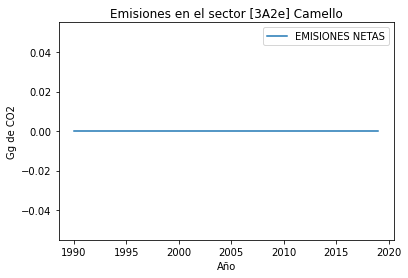

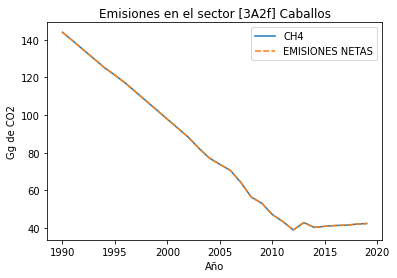

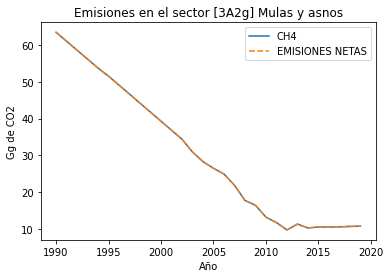

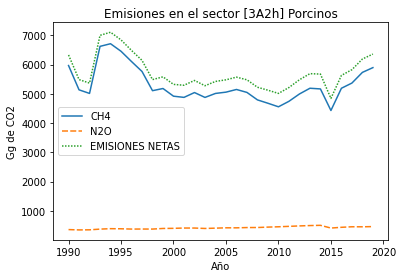

In [14]:
for i in feats[60:120]:

  df = IPCC_por_cat[i]
  
  #Se eliminan las columnas que tienen solo ceros para no graficarlas
  df = df.loc[:, (df != 0).any(axis=0)]

  #Se eliminan las columnas vacías (NaN)
  df = df.dropna(axis='columns')

  df = df.set_index("ANIO", drop=True)

  #Se convierten las strings que contienen números separados por comas a floats
  df = df.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

  df = df.apply(pd.to_numeric)

  #df.replace(0, np.nan, inplace=True)

  #Se guarda el nuevo dataframe ordenado del sector en un nuevo diccionario
  IPCC_por_cat_limpio[i] = df

  #Se crea la gráfica
  plt.figure()
  ax = sns.lineplot(data=df)
  ax.set(xlabel = "Año", ylabel='Gg de CO2', title = "Emisiones en el sector %s" % i.strip())
  plt.show()


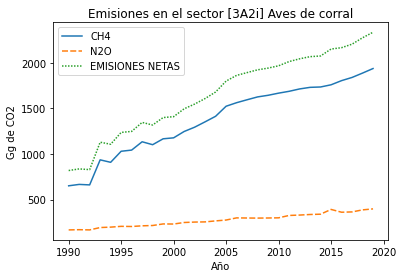

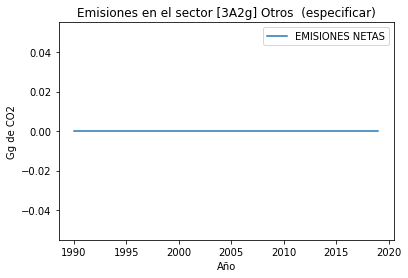

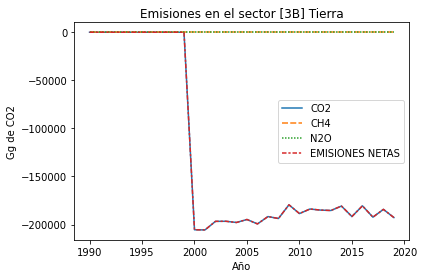

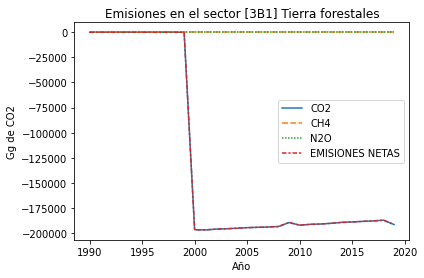

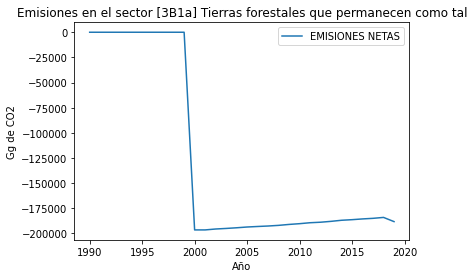

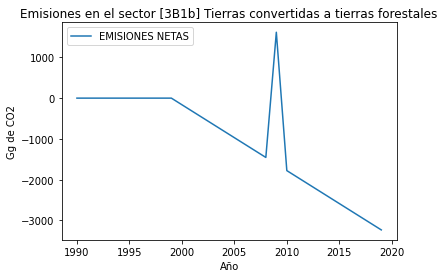

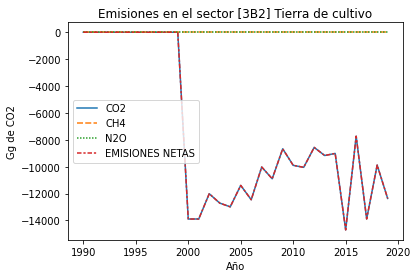

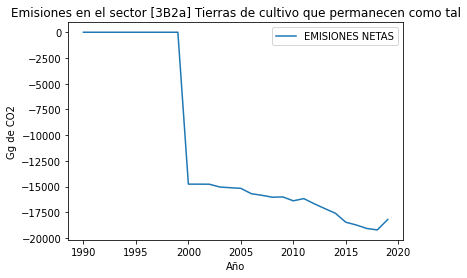

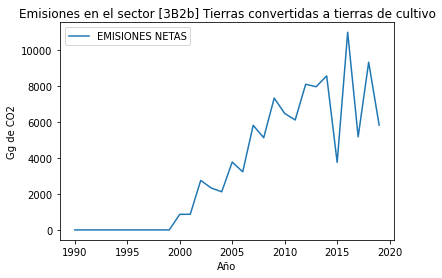

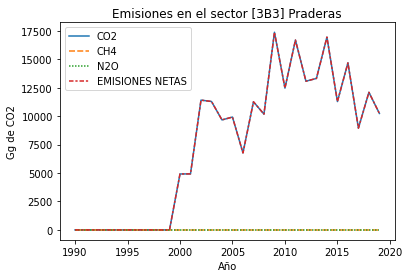

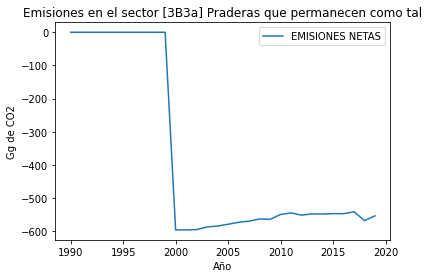

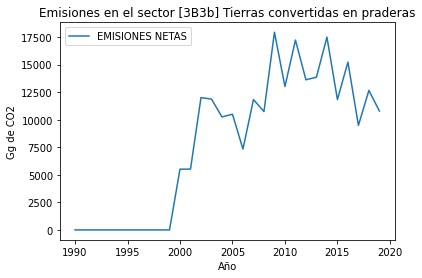

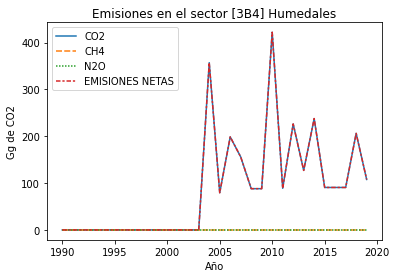

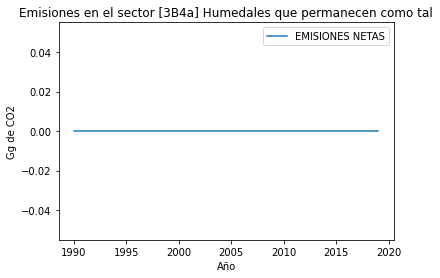

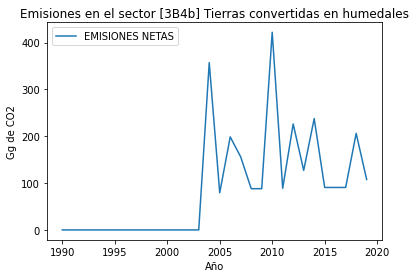

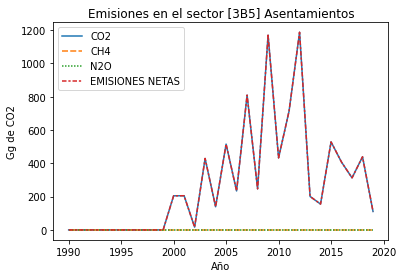

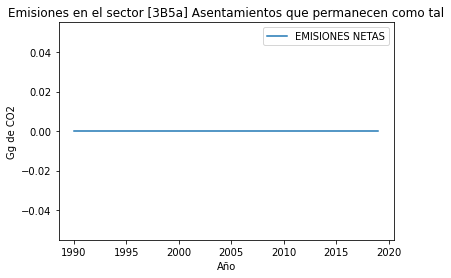

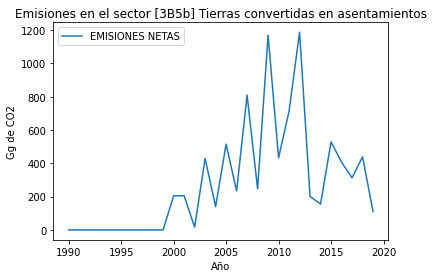

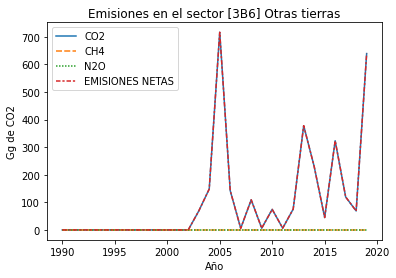

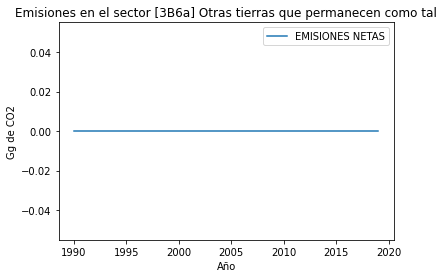

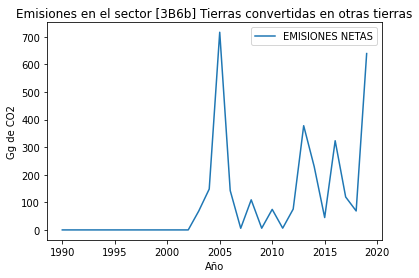

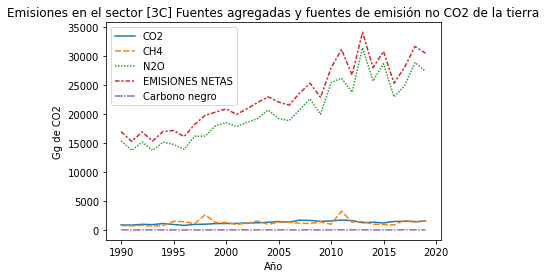

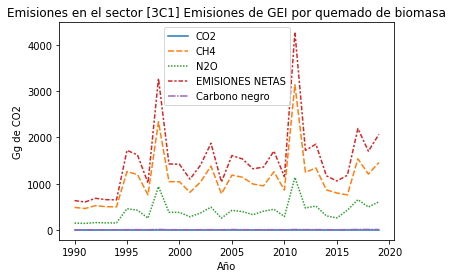

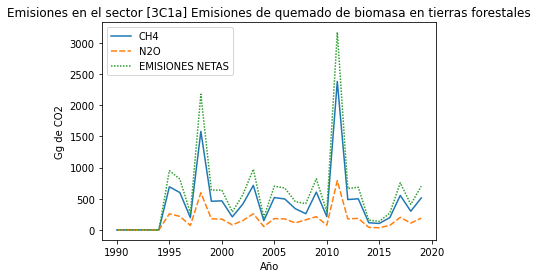

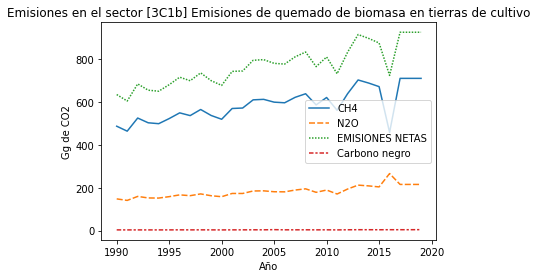

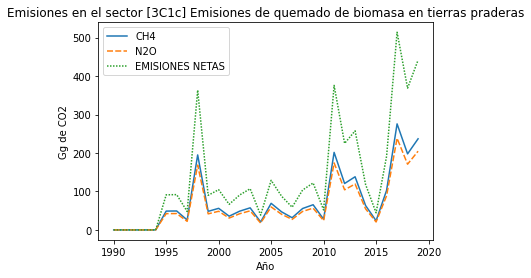

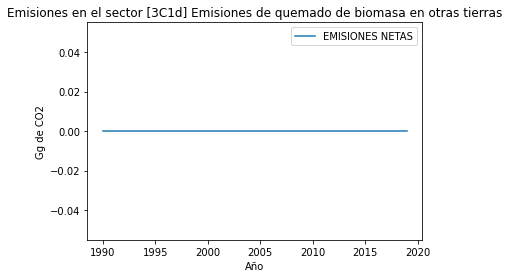

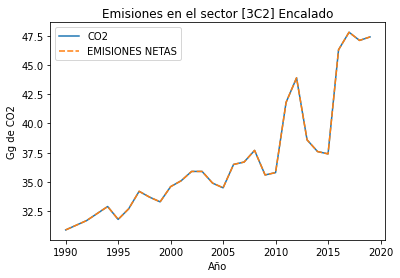

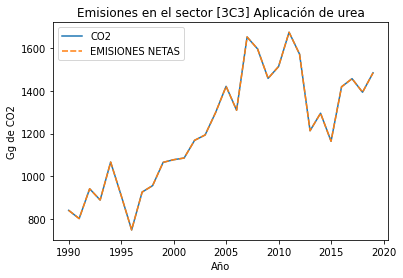

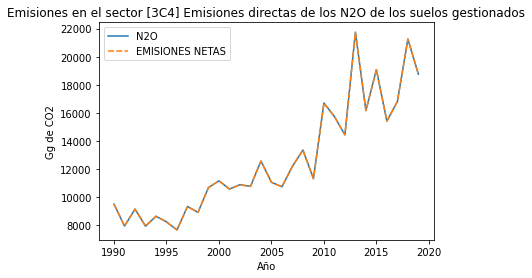

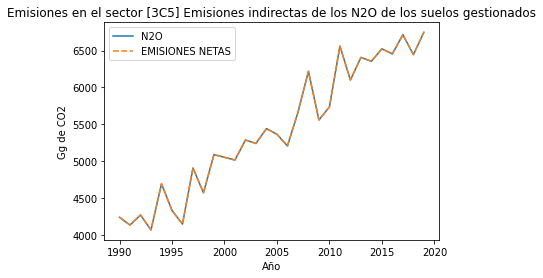

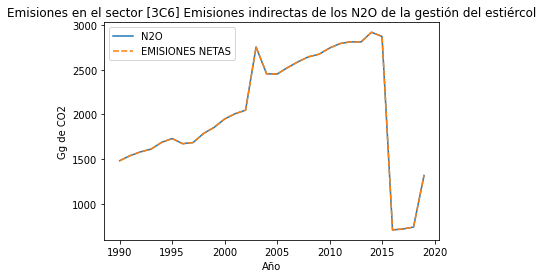

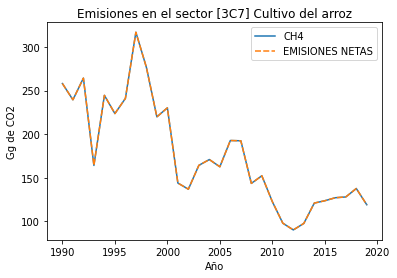

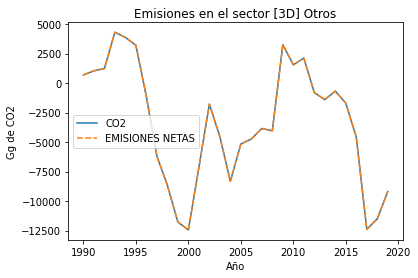

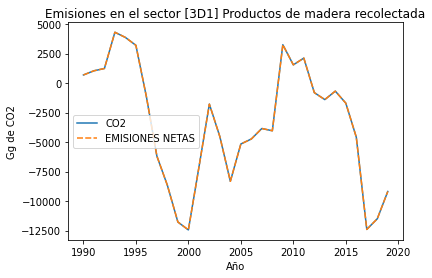

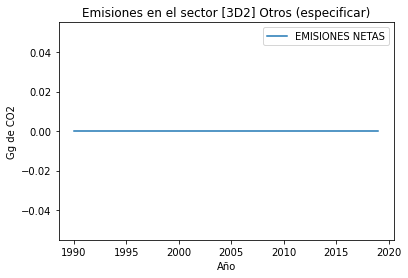

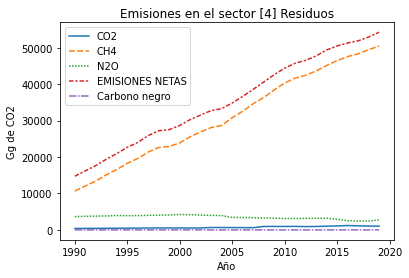

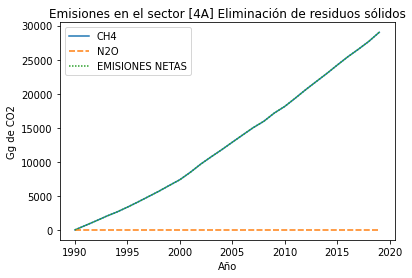

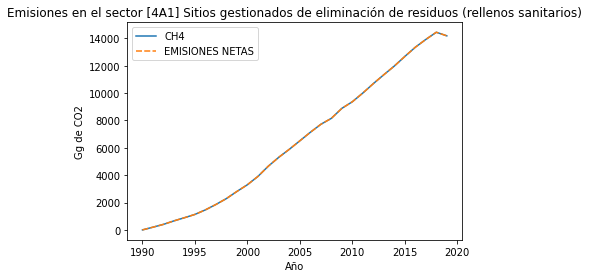

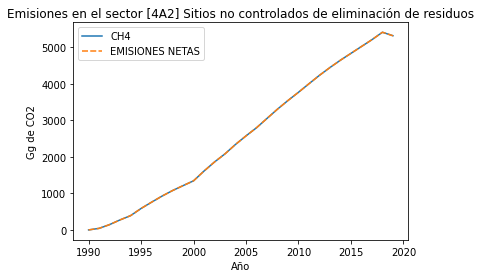

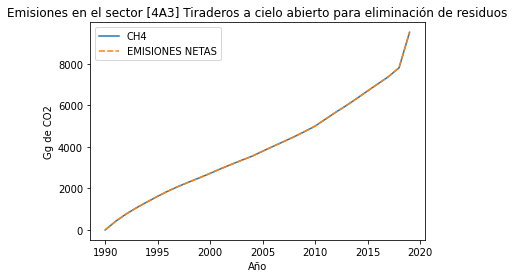

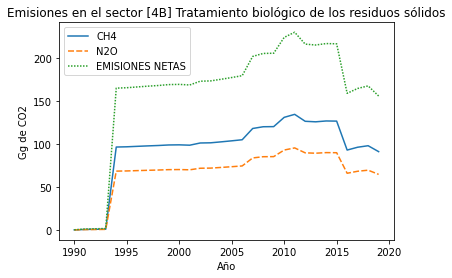

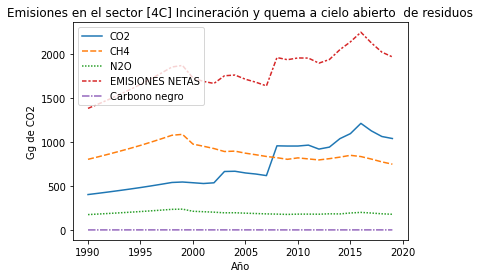

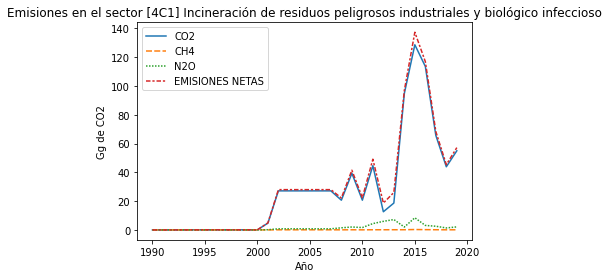

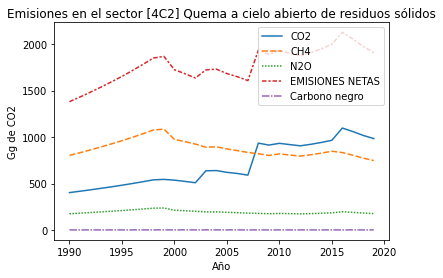

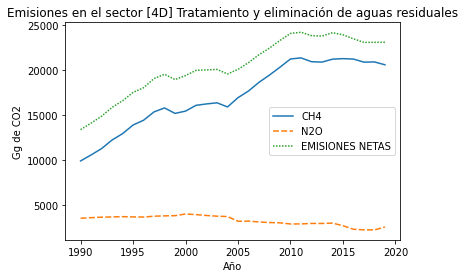

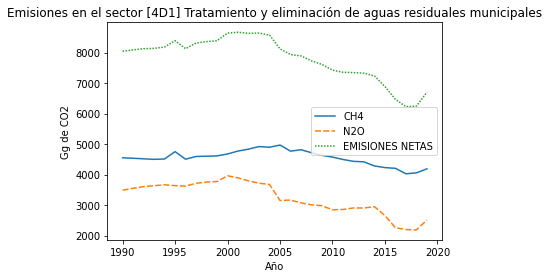

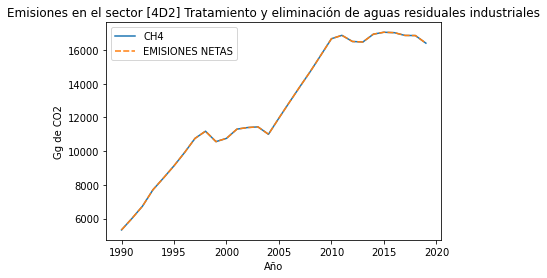

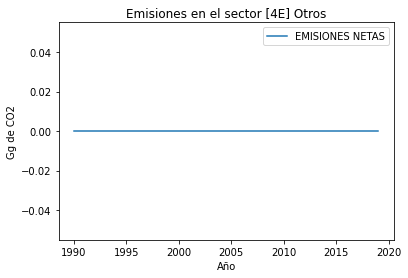

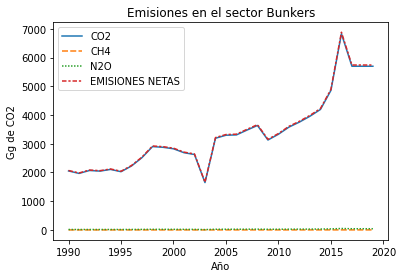

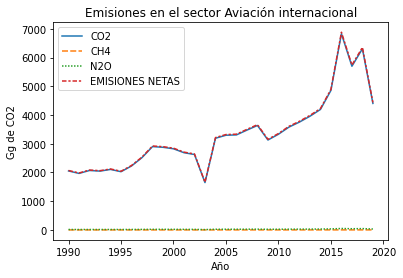

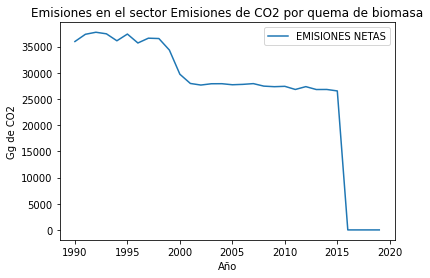

In [15]:
for i in feats[120:]:

  df = IPCC_por_cat[i]
    
  #Se eliminan las columnas que tienen solo ceros para no graficarlas
  df = df.loc[:, (df != 0).any(axis=0)]
  
  #Se eliminan las columnas vacías
  df = df.dropna(axis='columns')

  df = df.set_index("ANIO", drop=True)

  #Se convierten las strings que contienen números separados por comas a floats
  df = df.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

  df = df.apply(pd.to_numeric)

  #Se guarda el nuevo dataframe ordenado del sector en un nuevo diccionario
  IPCC_por_cat_limpio[i] = df

  #Se crea la gráfica
  plt.figure()
  ax = sns.lineplot(data=df)
  ax.set(xlabel = "Año", ylabel='Gg de CO2', title = "Emisiones en el sector %s" % i.strip())
  plt.show()

Se elabora el dataframe con los datos de las emisiones netas por año

In [16]:
df = IPCC_por_cat['EMISIONES NETAS (Gg de CO2e)']

df = df.iloc[::2]

df = df.drop(columns={"ANIO"})

df.index = list(range(1990, 2020))

print(df)

              CO2          CH4  ... EMISIONES NETAS Carbono negro
1990  319,999.845  117,840.420  ...     467,413.124        77.557
1991  329,716.353  119,392.867  ...     477,528.929        79.090
1992  333,049.712  117,998.461  ...     479,929.693        80.717
1993  338,075.107  118,275.355  ...     483,660.292        81.467
1994  360,853.348  124,026.181  ...     513,962.001        84.567
1995  347,496.645  127,038.457  ...     503,565.252        85.660
1996  359,553.271  131,254.597  ...     520,544.404        86.056
1997  375,317.236  138,365.119  ...     545,797.282        90.364
1998  393,944.487  143,331.786  ...     569,164.532       101.612
1999  386,967.007  136,486.779  ...     557,365.513        91.850
2000  195,440.705  139,956.673  ...     369,924.815        92.031
2001  197,460.695  140,413.078  ...     371,241.398        85.791
2002  229,882.008  143,348.720  ...     407,964.744        82.257
2003  224,329.118  145,781.654  ...     405,714.974        80.546
2004  238,

Se evalúan las columnas del dataframe obtenido utilizando la función info.gain

In [17]:
from info_gain import info_gain

ig = {}
feats = df.loc[:, df.columns] #Las feats corresponden a las columnas del dataset (los gases de emisión)
labels = df.index #Las etiquetas corresponden al índice del dataframe (los años)
for column in feats: # itero para cada columna del dataset
  values = feats[column] # obtengo la columna indicada por "column"
  ig[column] = info_gain.info_gain_ratio(values, labels) # calculo la proporción infogain para esa columna y la agrego a un diccionario

print(ig)

{'CO2': 0.6931471805599452, 'CH4': 0.6931471805599452, 'N2O': 0.6931471805599452, 'HFC-23': 0.6931471805599452, 'HFC-410A': 0.513964814545995, 'HFC-43-10-mee': 0.23119180950994334, 'HFC-125': 0.3659567673339592, 'HFC-134': 0.17500987655040678, 'HFC-134a': 0.5367287014077389, 'HFC-404A': 0.3659567673339592, 'HFC-407C': 0.3659567673339592, 'HFC-507a': 0.3659567673339592, 'HFC-152a': 0.23119180950994334, 'HFC-227ea': 0.23119180950994334, 'HFC-236fa': 0.2032485671630223, 'HFC-365mfc/227ea': 0.17500987655040678, 'HFC-365mfc': 0.3659567673339592, 'HFC-245fa': 0.2588261650651819, 'HFC-32': 0.19224973003744983, 'CF4': 0.6931471805599452, 'C2F6': 0.6931471805599452, 'C3F8': 0.5801392107176527, 'C4F6': 0.049915526344491645, 'c-C4F8': 0.5801392107176527, 'C5F8': 0.19022105398954905, 'NF3': 0.5801392107176527, 'SF6': 0.6931471805599452, 'EMISIONES NETAS': 0.6931471805599452, 'Carbono negro': 0.6931471805599452}


Se lee el archivo con los datos de temperaturas medias

In [18]:
url = "https://github.com/AdrianDiazGaxiola/Proyecto-Final/raw/main/Data/DataFrames%20Combinados/Temp%2BPrec%2BCic.csv"
df_prev = pd.read_csv(url)

#df_prev.index = list(range(2003, 2021))
#df_prev = df_prev.drop(index=2020)
#df_prev = df_prev.drop(columns = {"ANIO", "MES", "ENTIDAD"})

Se crea un dataframe con las emisiones netas anuales y la temperatura media anual nacional

In [25]:
T_Med = df_prev.T_Med.tolist()

#Se tomarán los datos de las temperaturas a partir de 1990 (mismo año donde comienza el IPCC)
T_Med = T_Med[5:-1]

df2 = df

#Se convierten los valores que están separados por comas a tipo float
df2 = df2.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

df2['T_Med'] = T_Med

print(df2)

             CO2         CH4  ...  Carbono negro      T_Med
1990  319999.845  117840.420  ...         77.557  20.747067
1991  329716.353  119392.867  ...         79.090  20.801480
1992  333049.712  117998.461  ...         80.717  20.459264
1993  338075.107  118275.355  ...         81.467  20.727411
1994  360853.348  124026.181  ...         84.567  21.130253
1995  347496.645  127038.457  ...         85.660  21.173363
1996  359553.271  131254.597  ...         86.056  20.828869
1997  375317.236  138365.119  ...         90.364  20.722723
1998  393944.487  143331.786  ...        101.612  21.239854
1999  386967.007  136486.779  ...         91.850  20.749099
2000  195440.705  139956.673  ...         92.031  20.816391
2001  197460.695  140413.078  ...         85.791  20.743932
2002  229882.008  143348.720  ...         82.257  20.936534
2003  224329.118  145781.654  ...         80.546  20.955060
2004  238241.812  144473.811  ...         77.495  20.867124
2005  253144.378  147152.584  ...       

Se encuentra la correlación entre los gases y la temperatura media nacional anual

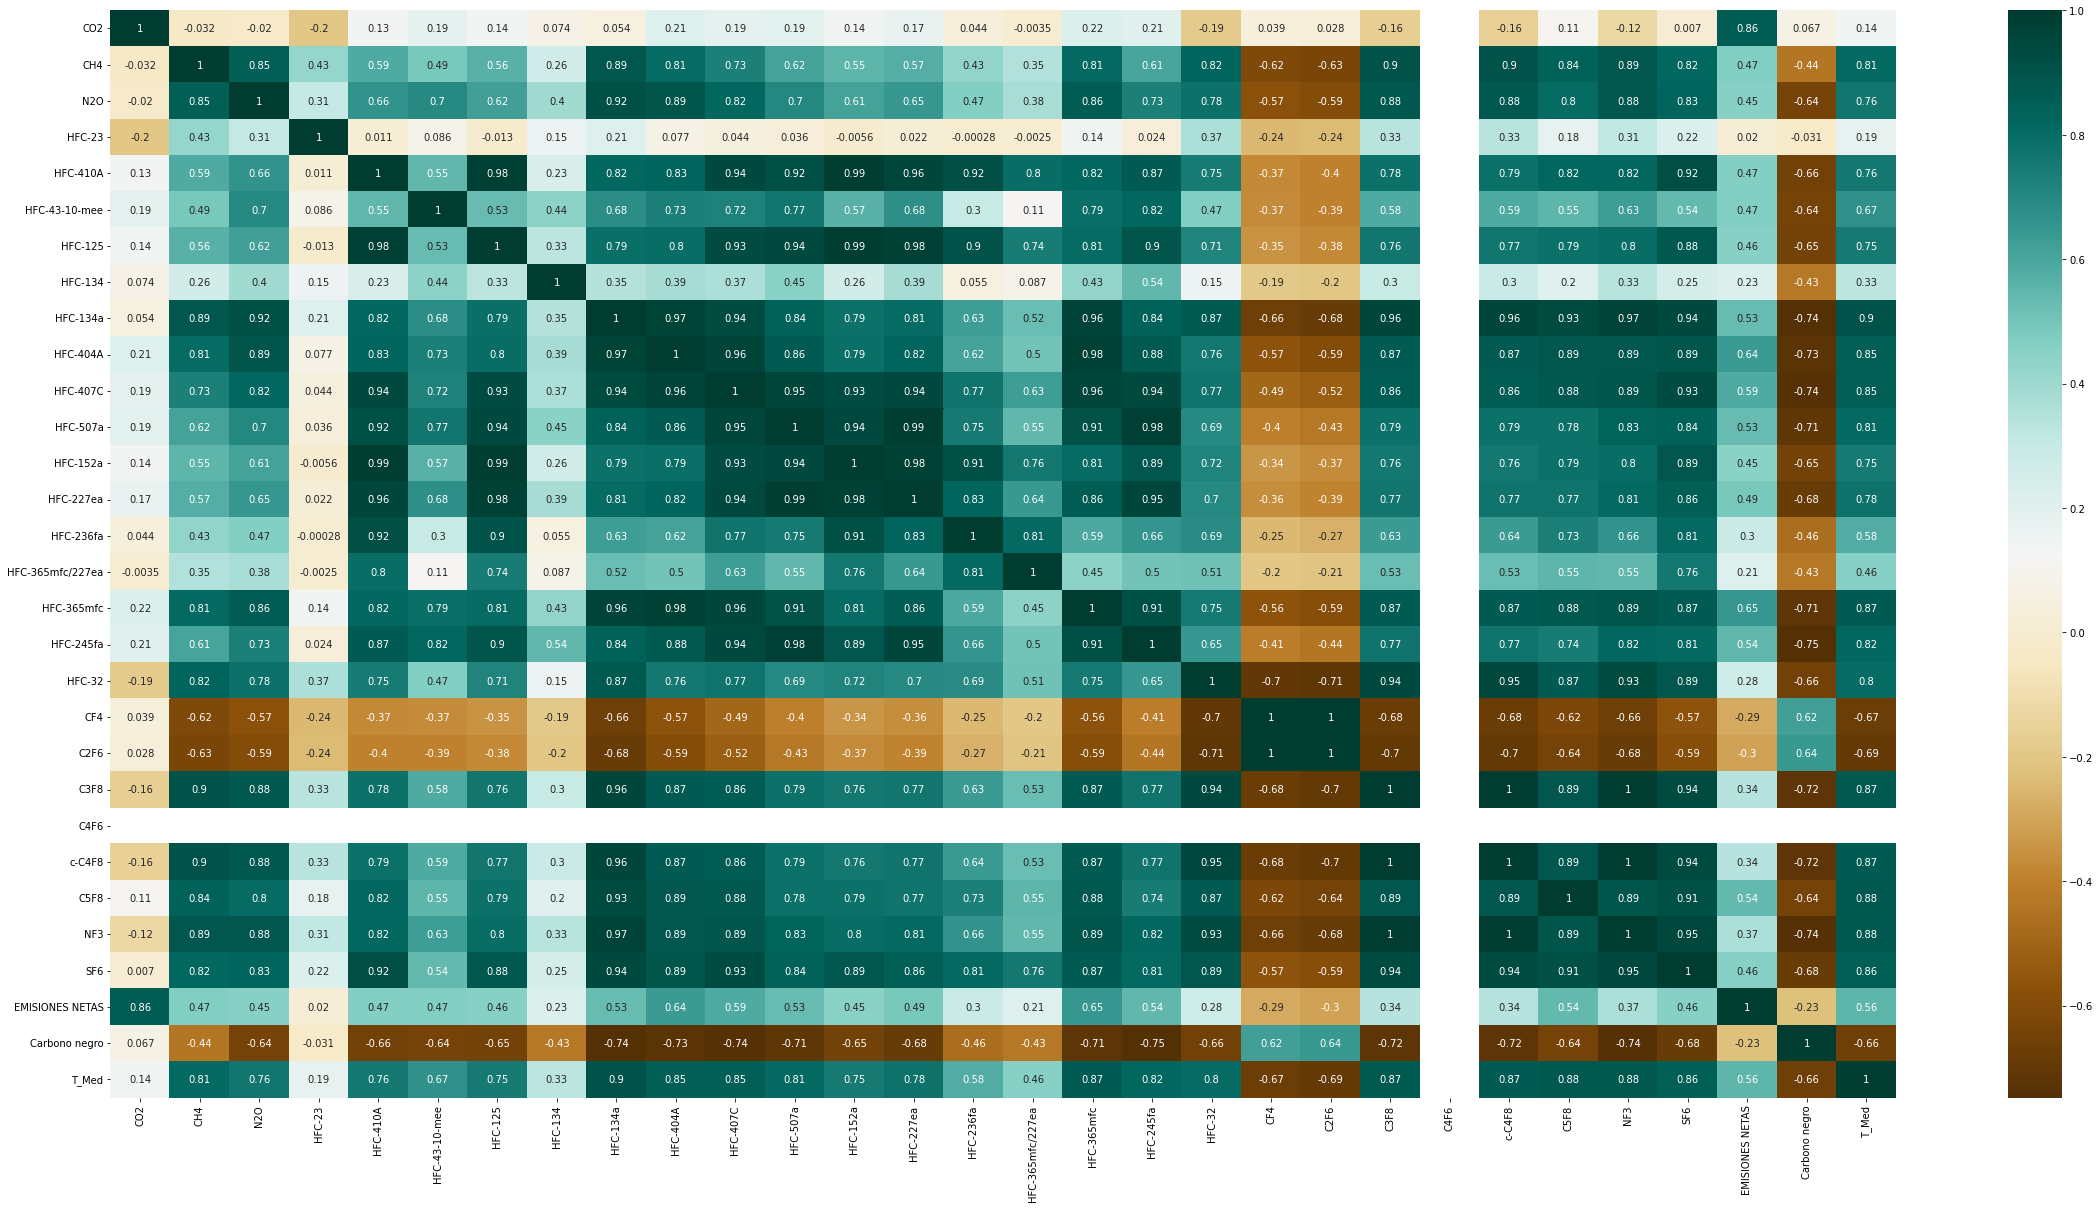

In [26]:
c = df2.corr()
plt.figure(figsize=(40, 20))

sns.heatmap(c,cmap="BrBG",annot=True)

Se toman los gases que muestran una correlación mayor o igual a 0.7 con la temperatura media

In [27]:
corr = c
corr = corr['T_Med']

corr = corr[corr>=0.7]

print(corr)

feats = corr.index.tolist()

feats.pop(len(feats)-1)
print(feats)

CH4           0.810424
N2O           0.761593
HFC-410A      0.758712
HFC-125       0.748381
HFC-134a      0.900754
HFC-404A      0.849908
HFC-407C      0.853431
HFC-507a      0.813362
HFC-152a      0.749851
HFC-227ea     0.779463
HFC-365mfc    0.869450
HFC-245fa     0.816420
HFC-32        0.802947
C3F8          0.870814
c-C4F8        0.870202
C5F8          0.882764
NF3           0.883598
SF6           0.856596
T_Med         1.000000
Name: T_Med, dtype: float64
['CH4', 'N2O', 'HFC-410A', 'HFC-125', 'HFC-134a', 'HFC-404A', 'HFC-407C', 'HFC-507a', 'HFC-152a', 'HFC-227ea', 'HFC-365mfc', 'HFC-245fa', 'HFC-32', 'C3F8', 'c-C4F8', 'C5F8', 'NF3', 'SF6']


<function matplotlib.pyplot.show>

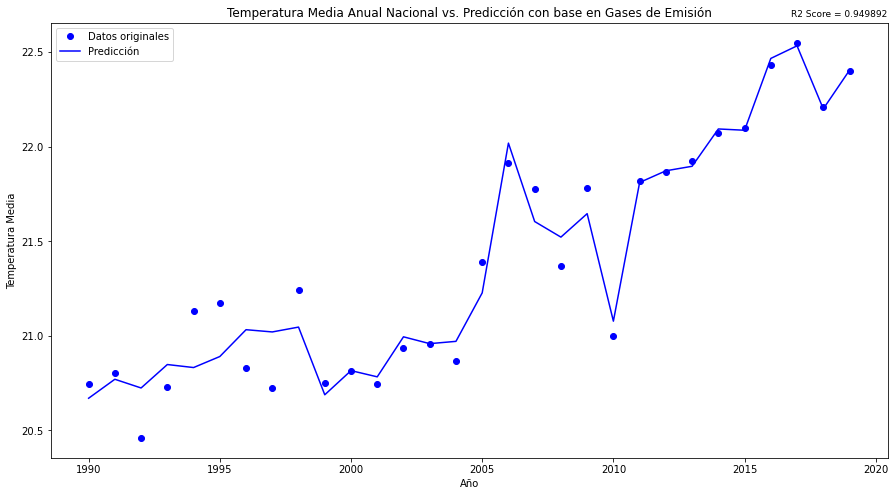

In [66]:
X = df2[['CH4', 'N2O', 'HFC-410A', 'HFC-125', 'HFC-134a', 'HFC-404A', 'HFC-407C', 'HFC-507a', 'HFC-152a', 'HFC-227ea', 'HFC-365mfc', 'HFC-245fa', 'HFC-32', 'C3F8', 'c-C4F8', 'C5F8', 'NF3', 'SF6']]
y = df2['T_Med']

años = list(range(1990, 2020))

regresion = LinearRegression()
regresion.fit(X, y)

plt.figure(figsize=(15,8))
plt.plot(años, y, 'bo', label = "Datos originales")
plt.plot(años, regresion.predict(X), '-b', label = "Predicción")

plt.title("Temperatura Media Anual Nacional vs. Predicción con base en Gases de Emisión")
plt.xlabel("Año")
plt.ylabel("Temperatura Media")

coef = r2_score(y, regresion.predict(X))
r2_title = "R2 Score = %f" % coef
plt.title(r2_title,  loc = 'right', fontsize=9)

plt.legend(loc='best')
plt.show


             CH4        N2O  HFC-410A  ...      C5F8    NF3      SF6
2012  160183.734  38281.439   307.610  ...  0.000001  1.264  164.340
2013  163464.872  45831.028   408.771  ...  0.000001  1.513  177.917
2014  168613.860  40075.080   513.503  ...  0.000001  1.675  185.862
2015  168025.655  42953.349   642.530  ...  0.000001  1.826  200.840
2016  174362.998  36897.138   890.730  ...  0.000001  1.968  217.012
2017  170958.542  38627.529  1172.566  ...  0.000002  2.125  257.089
2018  173705.912  42778.197  1486.686  ...  0.000002  2.272  278.664
2019  175558.470  41190.820  1848.070  ...  0.000002  2.474  400.916

[8 rows x 18 columns]
2012    21.866667
2013    21.925000
2014    22.075000
2015    22.100000
2016    22.433333
2017    22.550000
2018    22.208333
2019    22.400000
Name: T_Med, dtype: float64


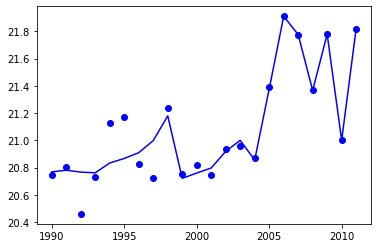

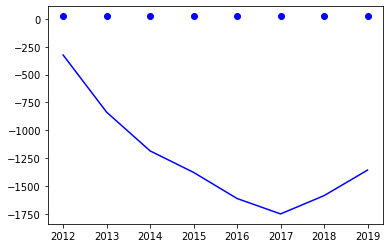

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=False)

regresion2 = LinearRegression()
regresion2.fit(X_train, y_train)

años2 = años[:-8]

plt.plot(años2, y_train, 'bo',label='Temperaturas Mínimas')
plt.plot(años2, regresion2.predict(X_train), '-b')#label='Tendencia Temp. Mín.')

años3 = años[-8:]

print(X_test)
print(y_test)

plt.figure()
plt.plot(años3, y_test, 'bo',label='Temperaturas Mínimas')
plt.plot(años3, regresion2.predict(X_test), '-b')#label='Tendencia Temp. Mín.')


Se combinan los dataframes

In [ ]:
df2 = df[13:]

#Se convierten los valores que están separados por comas a tipo float
df2 = df2.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

df_completo = pd.concat([df_prev, df2], axis=1) 

df_completo = df_completo.apply(pd.to_numeric)

print(df_completo)

          T_Max      T_Min      T_Med  ...      SF6  EMISIONES NETAS  Carbono negro
2003  28.643543  13.266576  20.955060  ...   97.371       405714.974         80.546
2004  28.345458  13.388790  20.867124  ...  107.472       420627.806         77.495
2005  28.967507  13.815767  21.391637  ...  114.306       437015.317         80.434
2006  29.215505  14.607056  21.911281  ...  117.440       449187.779         74.240
2007  29.348220  14.673085  21.776355  ...  137.070       491864.695         80.020
2008  28.983333  13.858333  21.366667  ...  140.204       538490.752         92.705
2009  29.266667  14.291667  21.779167  ...  140.893       542233.701         84.703
2010  28.483333  13.516667  21.000000  ...  156.247       531100.527         76.173
2011  29.658333  13.975000  21.820833  ...  161.515       554017.405         78.607
2012  29.138333  14.504167  21.866667  ...  164.340       536631.846         71.996
2013  29.150000  14.708333  21.925000  ...  177.917       548655.579        

Se evalúan las columnas del dataframe creado con la función info.gain()

In [ ]:
ig = {}
feats = df_completo.loc[:, df_completo.columns] #Las feats corresponden a las columnas del dataset (los gases de emisión)
labels = df_completo.index #Las etiquetas corresponden al índice del dataframe (los años)
for column in feats: # itero para cada columna del dataset
  values = feats[column] # obtengo la columna indicada por "column"
  ig[column] = info_gain.info_gain_ratio(values, labels) # calculo la proporción infogain para esa columna y la agrego a un diccionario

print(ig)

{'T_Max': 0.6931471805599453, 'T_Min': 0.6931471805599453, 'T_Med': 0.6931471805599453, 'Precipitacion': 0.6931471805599453, 'D0': 0.6931471805599453, 'D1': 0.6931471805599453, 'D2': 0.6931471805599453, 'D3': 0.6931471805599453, 'D4': 0.5384336774450834, 'Total_Sequías': 0.6931471805599453, 'DT': 0.36177736216327516, 'TT': 0.4586318734489843, 'H1': 0.371299896392041, 'H2': 0.2581311828747759, 'H3': 0.14148759490207857, 'H4': 0.19333136129539782, 'H5': 0.1414875949020786, 'Total_Ciclones': 0.5060629485078781, 'CO2': 0.6931471805599453, 'CH4': 0.6931471805599453, 'N2O': 0.6931471805599453, 'HFC-23': 0.6931471805599453, 'HFC-410A': 0.6931471805599453, 'HFC-43-10-mee': 0.4085607302065827, 'HFC-125': 0.613345376563846, 'HFC-134': 0.31355246510339346, 'HFC-134a': 0.6931471805599453, 'HFC-404A': 0.613345376563846, 'HFC-407C': 0.613345376563846, 'HFC-507a': 0.613345376563846, 'HFC-152a': 0.4085607302065827, 'HFC-227ea': 0.4085607302065827, 'HFC-236fa': 0.36177736216327516, 'HFC-365mfc/227ea': 

Se hace lo mismo con el dataframe que solo contiene los datos de temperaturas, precipitación y ciclones

In [ ]:
url = "https://github.com/AdrianDiazGaxiola/Proyecto-Final/raw/main/Data/DataFrames%20Combinados/Temp%2BPrec%2BCic.csv"
df_prev2 = pd.read_csv(url)

#Se cambia el índice del dataframe, y se toman los mismos años de los que se tiene datos del inventario de emisiones
df_prev2.index = list(range(1985, 2021))
df_prev2 = df_prev2.drop(index=2020)
df_prev2 = df_prev2[5:]
df_prev2 = df_prev2.drop(columns = {"ANIO", "MES", "ENTIDAD"})

In [ ]:
#Se convierten los valores que están separados por comas a tipo float
df = df.apply(lambda x: x.str.replace(',', '').astype(float), axis=1)

#Se adjuntan los dataframes
df_completo2 = pd.concat([df_prev2, df], axis=1) 

print(df_completo2)

          T_Max      T_Min      T_Med  ...      SF6  EMISIONES NETAS  Carbono negro
1990  28.128194  13.365940  20.747067  ...   36.517       467413.124         77.557
1991  28.305724  13.297236  20.801480  ...   39.036       477528.929         79.090
1992  27.621186  13.297342  20.459264  ...   43.437       479929.693         80.717
1993  28.294081  13.160741  20.727411  ...   47.776       483660.292         81.467
1994  28.786000  13.474506  21.130253  ...   51.493       513962.001         84.567
1995  28.865623  13.481103  21.173363  ...   53.408       503565.252         85.660
1996  28.696627  12.961110  20.828869  ...   62.733       520544.404         86.056
1997  28.390730  13.054715  20.722723  ...   65.246       545797.282         90.364
1998  29.135651  13.344057  21.239854  ...   66.592       569164.532        101.612
1999  28.786624  12.711573  20.749099  ...   68.658       557365.513         91.850
2000  28.688769  12.944013  20.816391  ...   72.048       369924.815        

Se evalúa nuevamente el dataframe con la función info.gain()

In [ ]:
ig = {}
feats = df_completo2.loc[:, df_completo2.columns] #Las feats corresponden a las columnas del dataset (los gases de emisión)
labels = df_completo2.index #Las etiquetas corresponden al índice del dataframe (los años)
for column in feats: # itero para cada columna del dataset
  values = feats[column] # obtengo la columna indicada por "column"
  ig[column] = info_gain.info_gain_ratio(values, labels) # calculo la proporción infogain para esa columna y la agrego a un diccionario

print(ig)

{'T_Max': 0.6931471805599452, 'T_Min': 0.6931471805599452, 'T_Med': 0.6931471805599452, 'Precipitacion': 0.6931471805599452, 'DT': 0.3004440596180738, 'TT': 0.37827512055892326, 'H1': 0.324079441118067, 'H2': 0.2311652605078746, 'H3': 0.12792322244945156, 'H4': 0.12765339366330744, 'H5': 0.07922214336077353, 'Total_Ciclones': 0.43591660095069673, 'CO2': 0.6931471805599452, 'CH4': 0.6931471805599452, 'N2O': 0.6931471805599452, 'HFC-23': 0.6931471805599452, 'HFC-410A': 0.513964814545995, 'HFC-43-10-mee': 0.23119180950994334, 'HFC-125': 0.3659567673339592, 'HFC-134': 0.17500987655040678, 'HFC-134a': 0.5367287014077389, 'HFC-404A': 0.3659567673339592, 'HFC-407C': 0.3659567673339592, 'HFC-507a': 0.3659567673339592, 'HFC-152a': 0.23119180950994334, 'HFC-227ea': 0.23119180950994334, 'HFC-236fa': 0.2032485671630223, 'HFC-365mfc/227ea': 0.17500987655040678, 'HFC-365mfc': 0.3659567673339592, 'HFC-245fa': 0.2588261650651819, 'HFC-32': 0.19224973003744983, 'CF4': 0.6931471805599452, 'C2F6': 0.6931

In [ ]:
print(df_completo.dtypes)

T_Max               float64
T_Min               float64
T_Med               float64
Precipitacion       float64
D0                    int64
D1                    int64
D2                    int64
D3                    int64
D4                    int64
Total_Sequías         int64
DT                    int64
TT                    int64
H1                    int64
H2                    int64
H3                    int64
H4                    int64
H5                    int64
Total_Ciclones        int64
CO2                 float64
CH4                 float64
N2O                 float64
HFC-23              float64
HFC-410A            float64
HFC-43-10-mee       float64
HFC-125             float64
HFC-134             float64
HFC-134a            float64
HFC-404A            float64
HFC-407C            float64
HFC-507a            float64
HFC-152a            float64
HFC-227ea           float64
HFC-236fa           float64
HFC-365mfc/227ea    float64
HFC-365mfc          float64
HFC-245fa           

Se encuentra la correlación entre variables mediante un heatmap

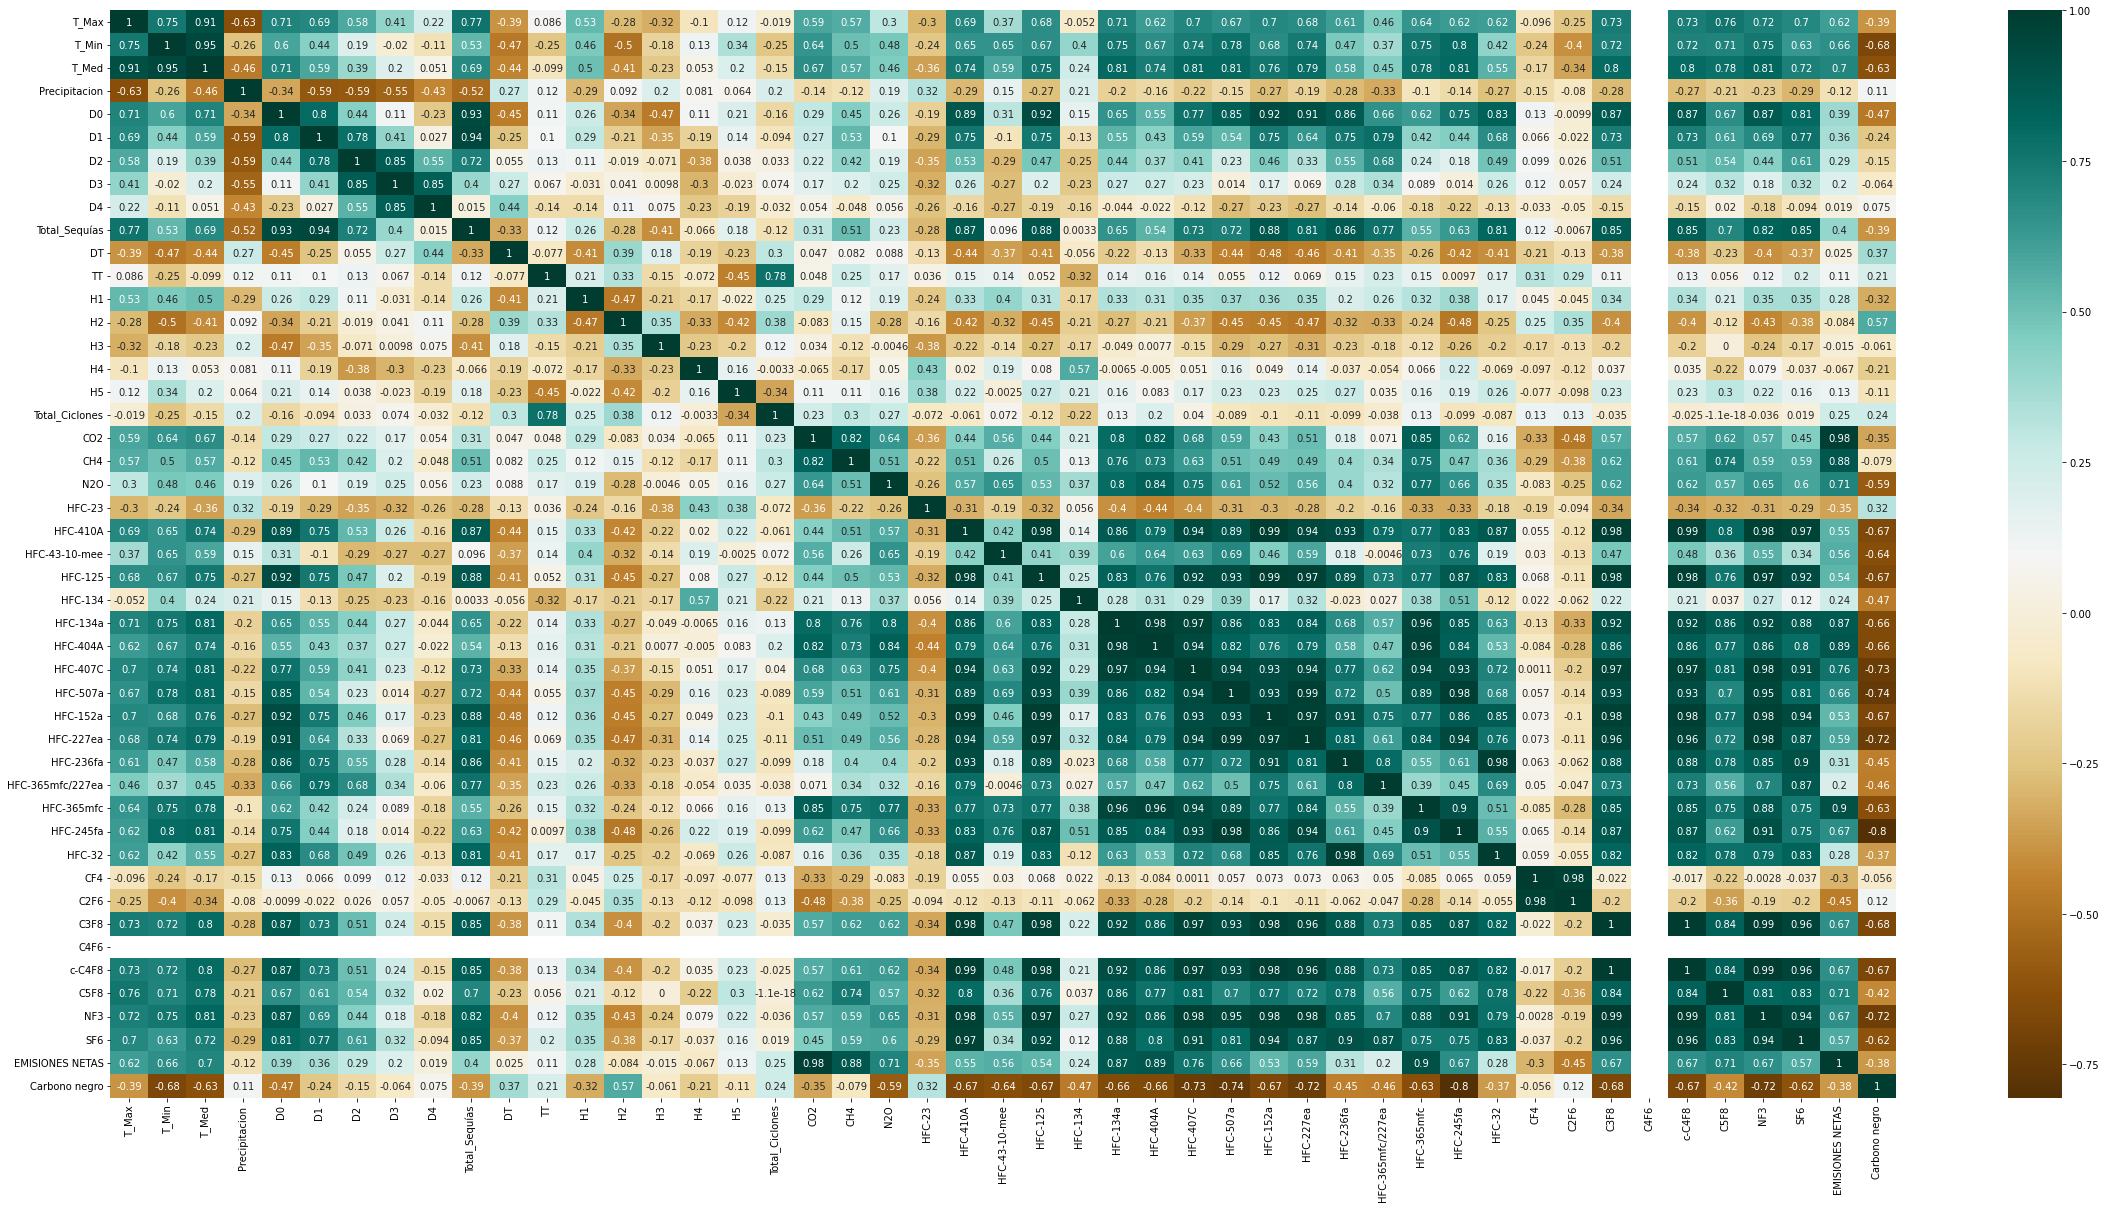

In [ ]:
plt.figure(figsize=(40, 20))
c= df_completo.corr()
#print(c)
sns.heatmap(c,cmap="BrBG",annot=True)

In [ ]:
print (c[c>=0.5])
c2 = c[c>=0.5]

                     T_Max     T_Min  ...  EMISIONES NETAS  Carbono negro
T_Max             1.000000  0.748379  ...         0.616174            NaN
T_Min             0.748379  1.000000  ...         0.661596            NaN
T_Med             0.909184  0.945073  ...         0.699770            NaN
Precipitacion          NaN       NaN  ...              NaN            NaN
D0                0.705765  0.597756  ...              NaN            NaN
D1                0.691870       NaN  ...              NaN            NaN
D2                0.582143       NaN  ...              NaN            NaN
D3                     NaN       NaN  ...              NaN            NaN
D4                     NaN       NaN  ...              NaN            NaN
Total_Sequías     0.765163  0.530900  ...              NaN            NaN
DT                     NaN       NaN  ...              NaN            NaN
TT                     NaN       NaN  ...              NaN            NaN
H1                0.526051       NaN  

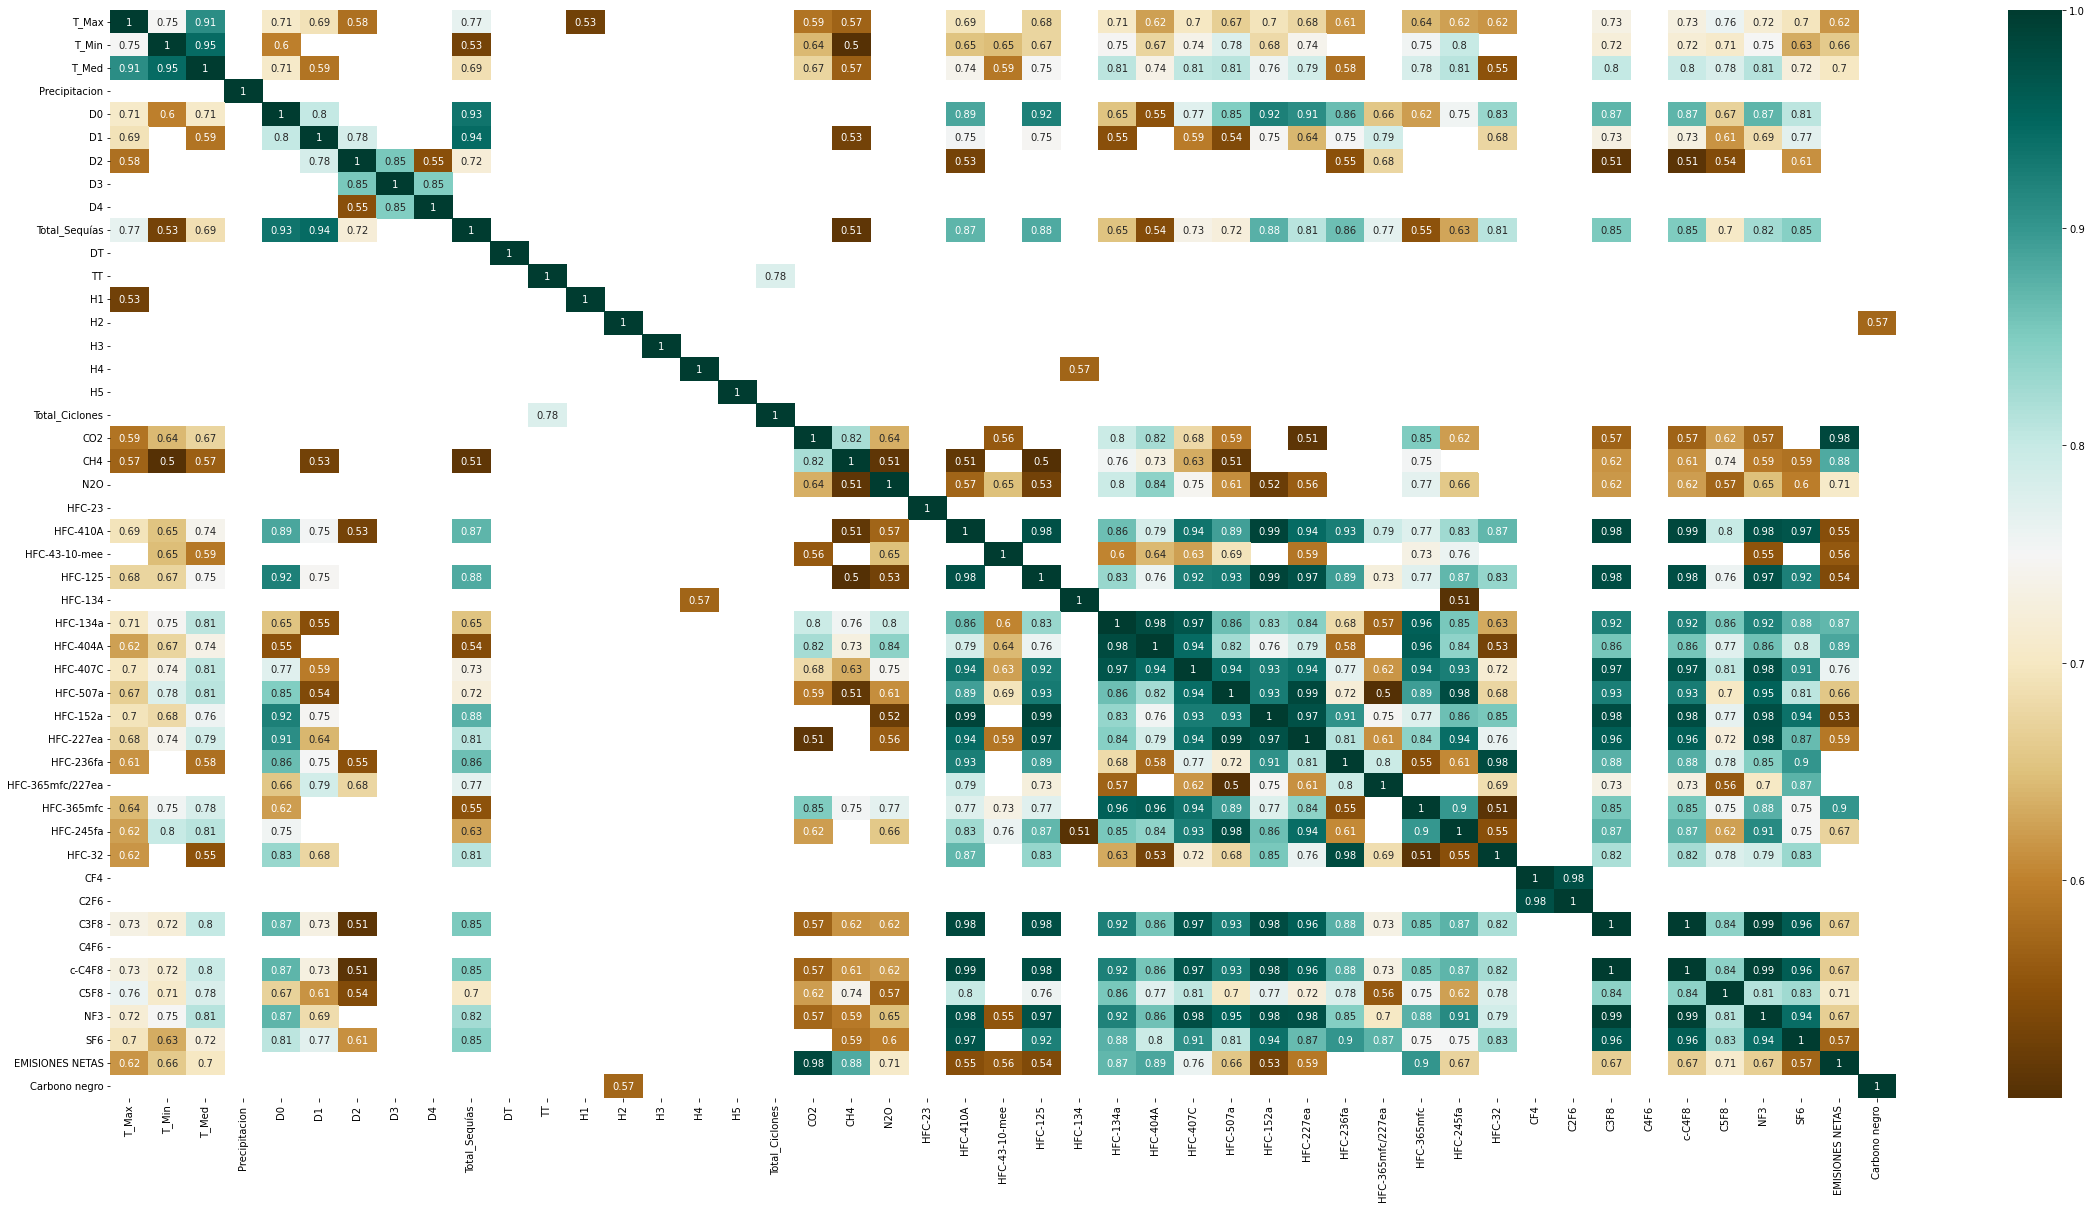

In [ ]:
plt.figure(figsize=(40, 20))
sns.heatmap(c2,cmap="BrBG",annot=True)

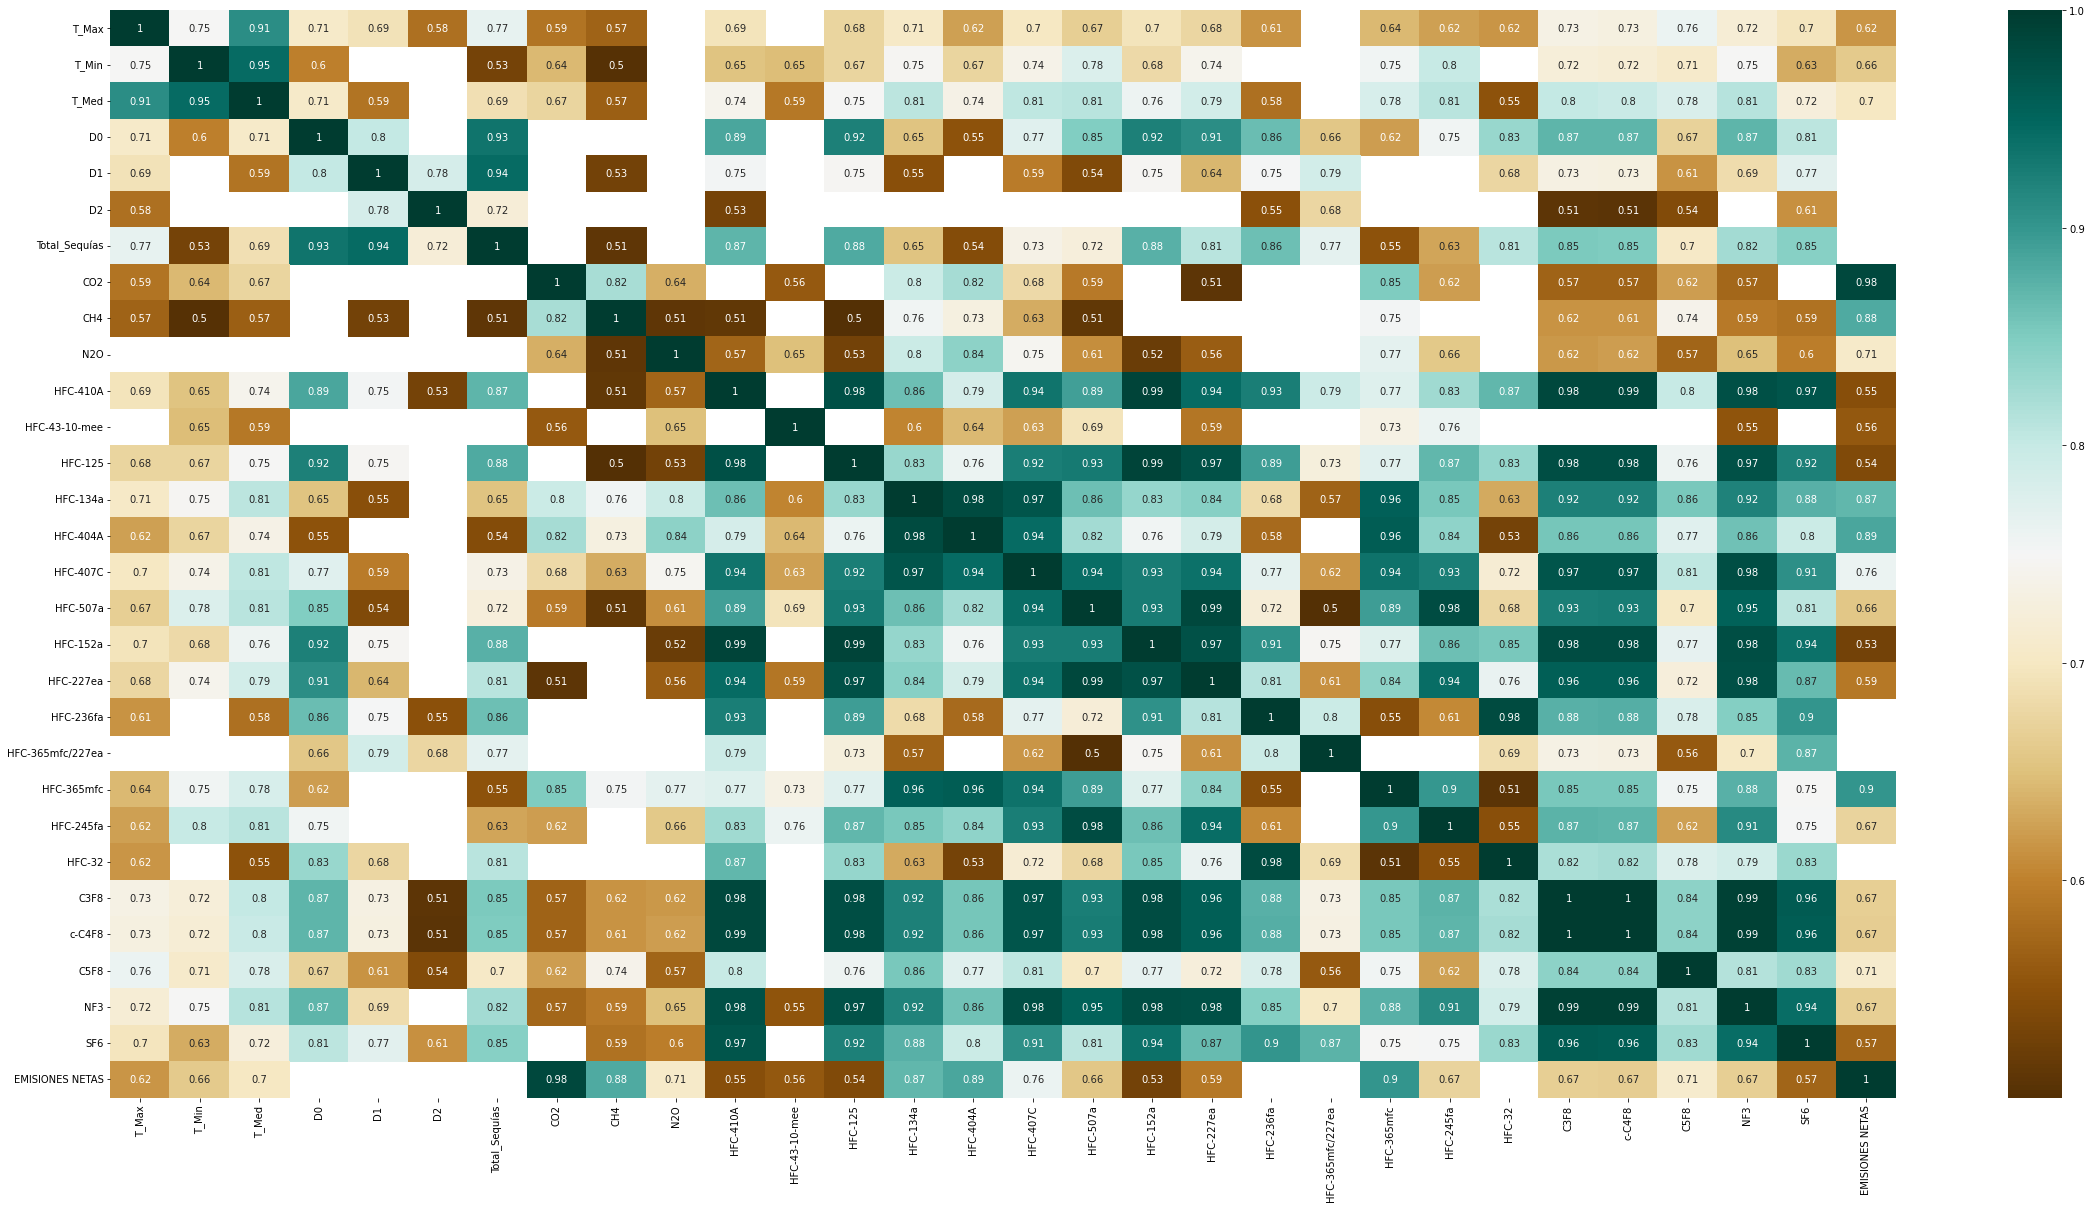

In [ ]:
c3 = c2

c3 = c3.dropna(thresh=4) 
c3 = c3.T
c3 = c3.dropna(thresh=4)

c3 = c3.T

plt.figure(figsize=(40, 20))
sns.heatmap(c3,cmap="BrBG",annot=True)

                    CH4  HFC-410A   HFC-125  ...      C5F8       NF3       SF6
T_Max          0.568917  0.693733  0.675507  ...  0.760175  0.718365  0.695704
T_Min          0.502939  0.652586  0.674924  ...  0.708858  0.749481  0.634236
T_Med          0.566203  0.741762  0.748117  ...  0.779591  0.812485  0.724301
D0                  NaN  0.885508  0.923232  ...  0.671161  0.871395  0.807870
D1             0.527933  0.753778  0.747441  ...  0.613638  0.685286  0.770020
Total_Sequías  0.510563  0.871664  0.881197  ...  0.703310  0.824399  0.845349

[6 rows x 19 columns]


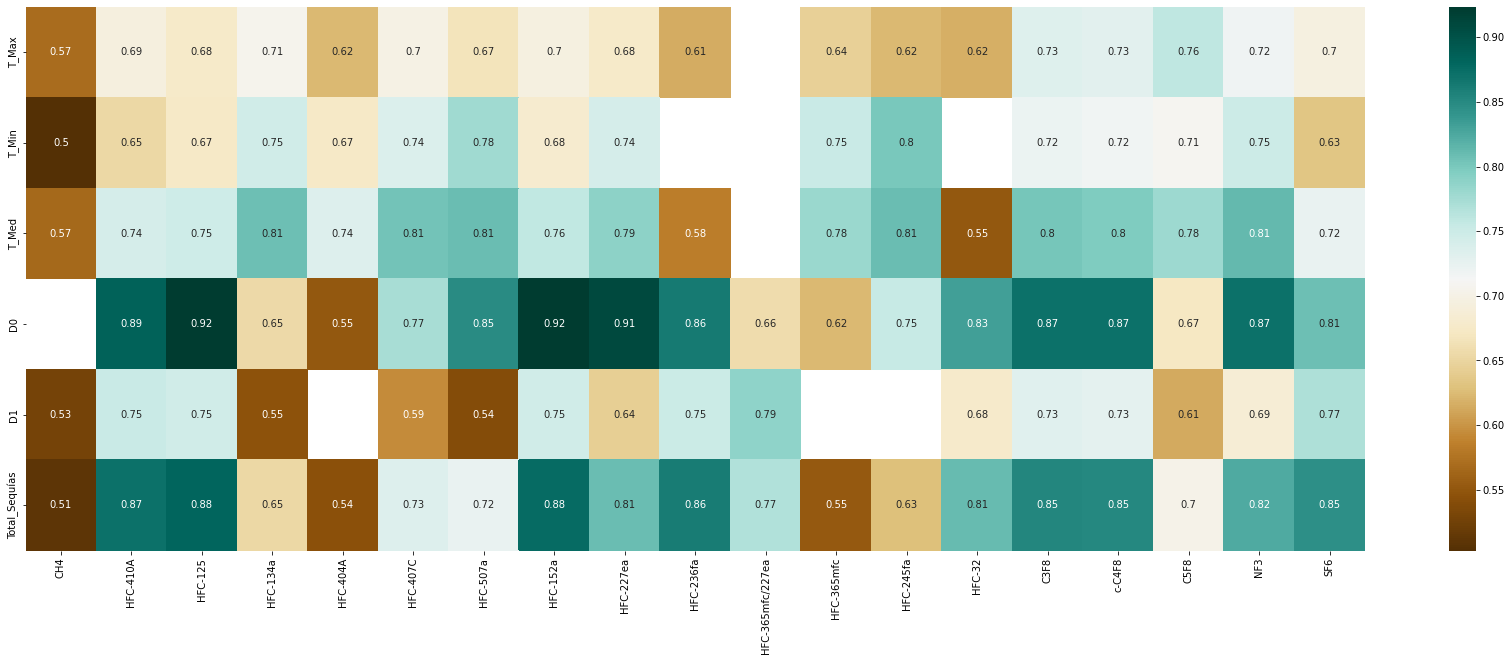

In [ ]:
c4 = c3

c4 = c4[c4.columns[0:7]]
c4 = c4.dropna(thresh=4) 
c4 = c4.T
c4 = c4[c4.columns[7:]]
c4 = c4.dropna(thresh=12)
print(c4)


plt.figure(figsize=(30, 10))
sns.heatmap(c4,cmap="BrBG",annot=True)
#c2 = c2.iloc[np.r_[0:7, 25:28]]